In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib as mpl
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
#import socket
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [3]:
# import socket
# socket.gethostname()

In [4]:
n_cpus = 4
#print('** epoch: {}'.format(mpd.get_epoch()))
if 'SLURM_CPUS_PER_TASK' in os.environ.keys():
    n_cpus = int(os.environ['SLURM_CPUS_PER_TASK'])
#
print(f'*** n_cpus: {n_cpus}')

*** n_cpus: 4


In [5]:
N_report_len = 180
end_dtm = dtm.datetime(2023,11,14)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
#delim_sacct='|'
delim_sacct='*'
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_sherlock_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file [{os.path.isfile(sacct_h5_file)}]: {sacct_h5_file}')

*** dates: 2023-05-18 - 2023-11-14
*** sacct_h5_file [True]: sacct_data/sacct_sherlock_pSERC_gNONE_uNone_20230518_20231114.h5


In [6]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose, delim=delim_sacct,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_sherlock_pSERC_gNONE_uNone_20230518_20231114.h5
**  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [7]:
SP=hpc_lib.SH_PART_obj()

print(f'*** Cols: {SACCT_obj.jobs_summary.dtype.names}')
print(f'*** CPUs: {SP.get_total_cpus(partitions="serc")}')
print(f'*** GPUs: {SP.get_total_gpus(partitions="serc")}')

*** Cols: ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')
*** CPUs: 9104
*** GPUs: 92


In [8]:
n_cpus_serc = SP.get_total_cpus(partitions='serc')
n_gpus_serc = SP.get_total_gpus(partitions='serc')
#
print(f'** n_cpus: {n_cpus_serc}, n_gpus: {n_gpus_serc}')
#
print('*** ', SP.SP)

** n_cpus: 9104, n_gpus: 92
***         partition_name partition_public  nodes_idle  nodes_total  \
normal         normal              yes           3          187   
bigmem         bigmem              yes           1            9   
gpu               gpu              yes           2           26   
dev               dev              yes           0            4   
hns               hns               no           0          105   
serc             serc               no          16          233   
owners         owners               no         105         1492   

        cpu_cores_idle  cpu_cores_total  cpu_cores_queued  gpus_idle  \
normal             203             5012             19612          0   
bigmem             157              504               828          0   
gpu                436              748               872         40   
dev                 88              104                 0         62   
hns                686             3728               808          0  

### SERC GPU activity

### GPUs:
For now, hijack the SACCT.get_active_cpus_layer_cake() function, but force the "CPUs" column to use GPUs.

In [9]:
gpu_layers = SACCT_obj.get_active_cpus_layer_cake(layer_field='Account', NCPUs=SACCT_obj.get_NGPUs())

/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:721: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if NCPUs is None or NCPUs=='':


*** DEBUG t_now: 19695.483571908346, t_max: 19674.44693287037


*** keys():  dict_keys(['N_cpu', 'N_jobs'])


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:3737: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


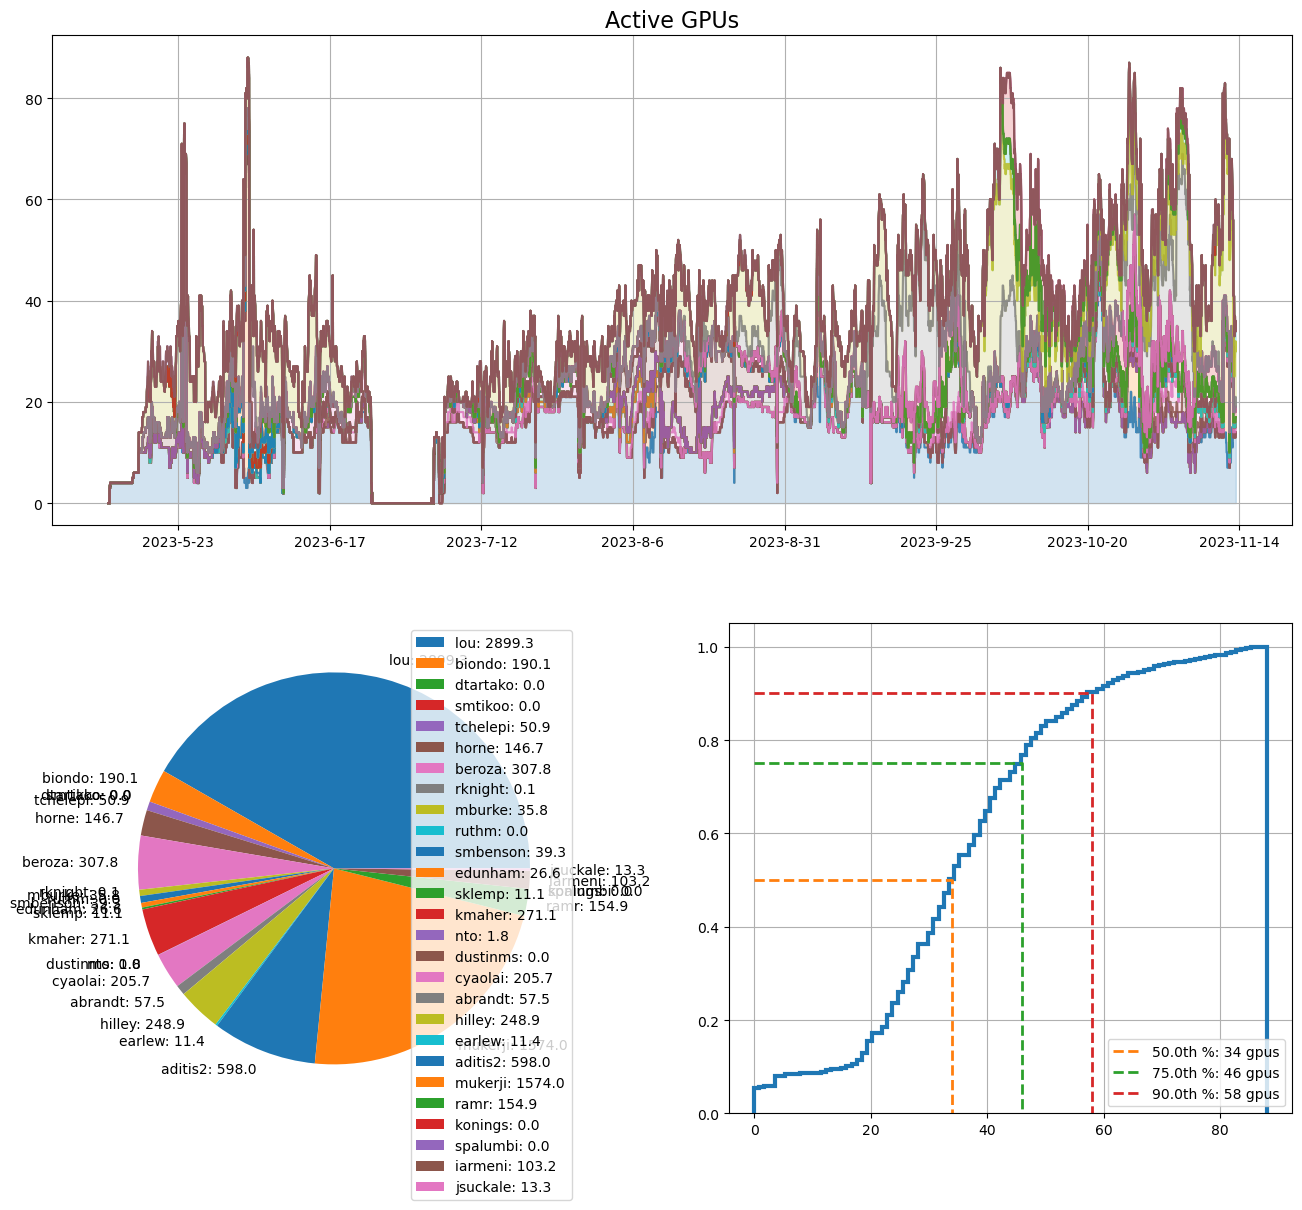

In [10]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
#print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_obj.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_obj.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
#print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(16,14))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc='upper right')
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


### Memory per GPU requests
- Question: How often are GPUs unavailable because of excessive memory reqeusts?
- Eg, on one particularly occasion a group was unable to allocate GPU resources, but there appeared to be approximately 20 GPUs available in SERC. It turnsout that one user was running 3 jobs requesting `~600 GB RAM` for a single GPU each, which effectively allocated 5 GPUs to each job -- unless other users made especially low memory requests.
- General observations:
  - Approximately 1 in 4 GPU jobs request >128 GB/GPU, effectively displacing >1 GPU_acail/GPU_req
  - This appears (anecdotally) to be an increasing trend
  - It is an expensive habit.
  - The CDF/quantile based availability chart is probably inaccurate.

***  1693406 9045
*** hh_gpu:  [   0.  128.  256.  384.  512.  640.  768.  896. 1024.]


/tmp/ipykernel_21095/2611506074.py:10: RuntimeWarning: divide by zero encountered in divide
  mem_per_cpu = (SACCT_obj['ReqMem'][ix_cpu] / SACCT_obj['NCPUS'][ix_cpu])/10**9


Text(0.5, 1.0, 'ReqMem[GB]/GPU')

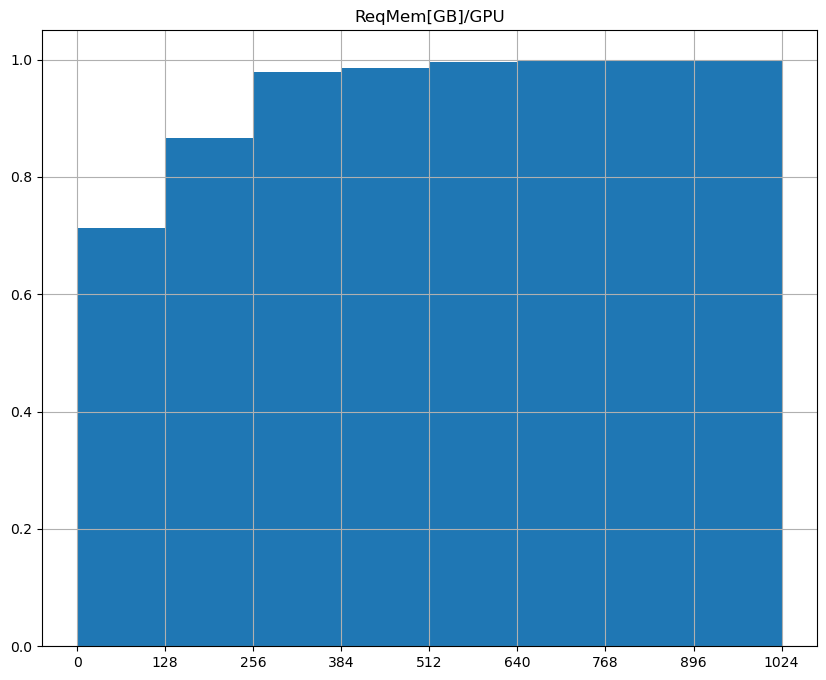

In [11]:
ix_gpu = SACCT_obj['NGPUs']>0
ix_cpu = numpy.invert(ix_gpu)
#
gpu_jobs = SACCT_obj.jobs_summary[ix_gpu]
#mem_per_gpu= SACCT_server[]
#
print('*** ', len(SACCT_obj.jobs_summary), len(gpu_jobs))
#
mem_per_gpu = (gpu_jobs['ReqMem']/gpu_jobs['NGPUs'])/10**9
mem_per_cpu = (SACCT_obj['ReqMem'][ix_cpu] / SACCT_obj['NCPUS'][ix_cpu])/10**9

#req_mem = SACCT_obj['ReqMem']/10**9.
#
fg = plt.figure(figsize=(10,8))
ax1 = fg.add_subplot(1,1,1)
#ax2 = fg.add_subplot(1,2,2)
#
hh_gpu = ax1.hist(mem_per_gpu, bins=[0, 128,256,384,512,640,768,896,1024], density=True, cumulative=True)
print('*** hh_gpu: ', hh_gpu[1])

##hh_cpu = ax2.hist(mem_per_cpu, bins=20)
#hh_cpu = ax2.hist( (SACCT_obj['ReqMem']/(1024**3)), bins=2)
#
#ax1.set_yscale('log')
#ax2.set_yscale('log')

#intervals = numpy.arange(0,9)*128
loc = mpl.ticker.MultipleLocator(base=128)
ax1.xaxis.set_major_locator(loc)

#ax1.grid()
ax1.yaxis.grid(True)
ax1.xaxis.grid(True)
#fg.suptitle('Requested Memory', size=16)
ax1.set_title('ReqMem[GB]/GPU')


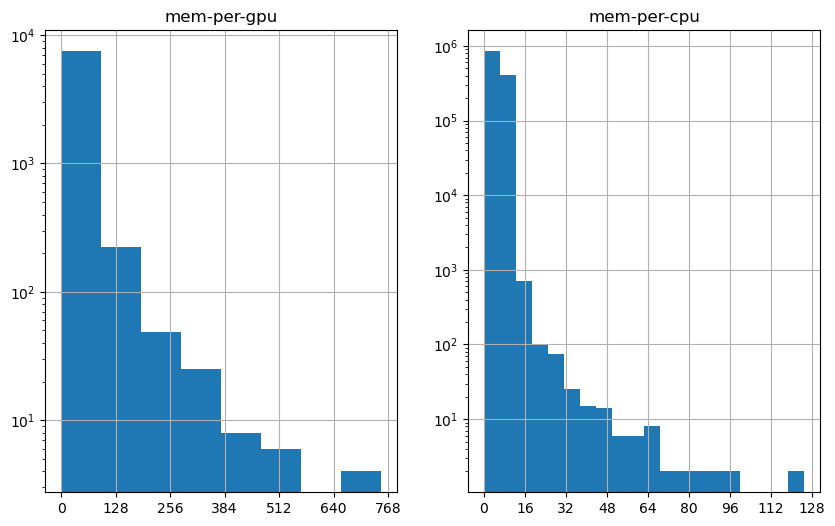

In [12]:
#print('** ', numpy.unique(SACCT_obj['NGPUs']))
ix_gpu = SACCT_obj['NGPUs']>0
ix_cpu = numpy.invert(ix_gpu)
#
sacct_gpus = SACCT_obj.jobs_summary[ix_gpu]
#
mem_per_gpu = (sacct_gpus['MaxRSS']/sacct_gpus['NGPUs'])/(1024**3.)
mem_per_cpu = (SACCT_obj['MaxRSS']/SACCT_obj['NCPUS'])/(1024**3.)
#
fg = plt.figure(figsize=(10,6))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
hh_gpu = ax1.hist(mem_per_gpu, bins=8)
ax1.set_yscale('log')
ax2.set_yscale('log')


#hh_cpu = ax2.hist(mem_per_cpu, bins=20)
hh_cpu = ax2.hist(mem_per_cpu, bins=20)
#
loc = mpl.ticker.MultipleLocator(base=128)
ax1.xaxis.set_major_locator(loc)
ax1.yaxis.grid()
ax1.xaxis.grid()

ax1.set_title('mem-per-gpu')
ax2.set_title('mem-per-cpu')
ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=16))
ax2.grid()
#fg.suptitle('MaxRSS', size=16)

In [13]:
print('*** ', SACCT_obj.jobs_summary.dtype.names)

***  ('index', 'User', 'Group', 'GID', 'Account', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'ReqMem', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


Text(619.8699494949494, 0.5, '% GPU_mem')

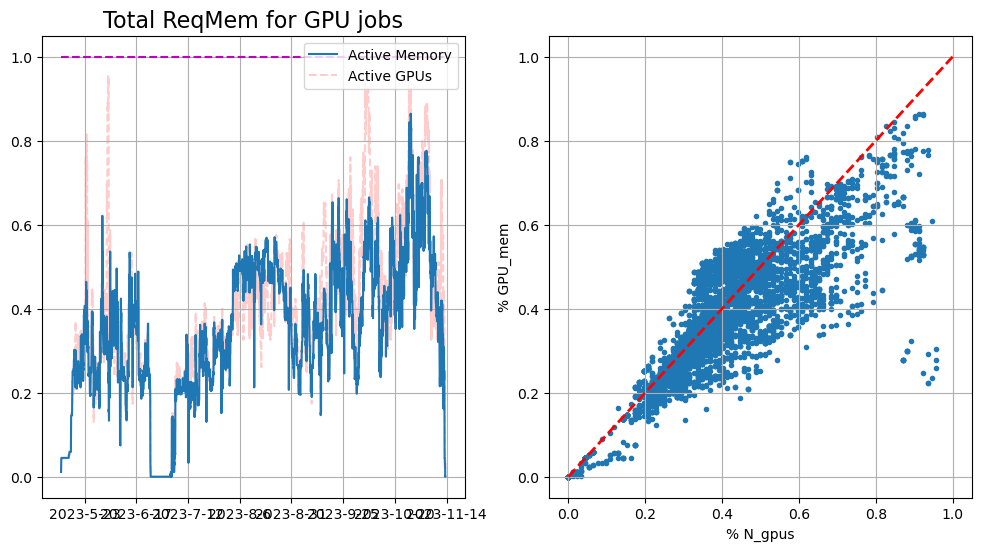

In [22]:
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot(1,2,1)
#ax1a = ax1.twinx()
ax2 = fg.add_subplot(1,2,2)
#
# trick the NCPU code to get a time series for requested memory; limit to GPU jobs with [ix_gpu]
active_req_mem = SACCT_obj.active_jobs_cpu(NCPUs=SACCT_obj['ReqMem'][ix_gpu], jobs_summary=SACCT_obj.jobs_summary[ix_gpu])
ARM = active_req_mem
active_gpus = SACCT_obj.active_jobs_cpu(NCPUs=SACCT_obj['NGPUs'][ix_gpu], jobs_summary=SACCT_obj.jobs_summary[ix_gpu])
#
total_mem = 10*1024*1024**3 + 2*192*1024**3 + 1*512
#total_mem = 10*1024*10**9 + 2*192*10**9
#
ax1.plot(ARM['time'], ARM['N_cpu']/total_mem, ls='-',zorder=11, label='Active Memory')
ax1.plot(active_gpus['time'], active_gpus['N_cpu']/92., ls='--', color='r', zorder=1, alpha=.2,
         label='Active GPUs')
#
#ax1.plot(ARM['time'][0::len(ARM['time'])-1], numpy.ones(2)*total_mem, ls='--', color='m')
ax1.plot(ARM['time'][0::len(ARM['time'])-1], numpy.ones(2), ls='--', color='m')
ax1.grid()
ax1.set_title('Total ReqMem for GPU jobs', size=16)
lbls = hpc_lib.fg_time_labels_to_dates(ax1)
ax1.legend(loc='upper right')
#
ax2.scatter(active_gpus['N_cpu']/92., ARM['N_cpu']/total_mem, marker='.')
ax2.plot([0., 1.], [0., 1.], color='r', lw=2, ls='--', zorder=11)
ax2.grid()
ax2.set_xlabel('% N_gpus')
ax2.set_ylabel('% GPU_mem')

### GPU efficiency and development habits
- Can we identify (in-)efficient use of GPUs?
- Development vs production run jobs?
- A direct measure of GPU activity does not appear to be available (eg, similar to UserCPU, etc.)
- Elapsed time vs CPU efficiency:
  - Is there a relationship between elapsed time and CPU efficiency that suggests development focused jobs?
  - Eg, shorter jobs (a few hours, <1 day) may represent development time
  - What about smaller memory requests? If I was doing dev work, I would do like, --mem-per-gpu=16g
  - SUMMARY (so far), wrt efficiency(time):
    - Not really -- at least not a universal relationship
    - For individual users, there are sometimes horizontal groupings at a fixed CPU efficiency level for various times. For eff>0, this (IMHO) suggests production runs, particularly for dt>1 day.
    - eg, see: imcbrear, jhchung1, jianhao, kashefi, lauraman
    - Note some figures indicate that -- quite likely, many GPUs are being reserved and then used either very very amazingly efficiently or extremely inefficiently (ie, almost zero CPU efficiency). These likely suggest interactive sessions left idle or jobs submtted that fail to use the GPU as intended.
    

In [15]:
# print('** ', gpu_jobs.dtype.names)
# for rw in gpu_jobs[0:10]:
#     print(f'**[{rw["JobID"].decode()}] {rw}')

In [16]:
gpu_users = numpy.unique(gpu_jobs['User']).astype(str)
print(f'*** [{len(gpu_users)}]  {gpu_users}')

*** [68]  ['aguilars' 'akawano' 'aljubrmj' 'amyfzou' 'andea98' 'anovosel' 'arlenlex'
 'bcornwel' 'cjr63' 'cooper96' 'cync03' 'dpfeng' 'ebalogun' 'gdifede'
 'gegewen' 'haipeng' 'hytang' 'ihigueme' 'imcbrear' 'jakin' 'jfranc'
 'jhchung1' 'jianhao' 'jiinjung' 'jthluke' 'ju1' 'juliojof' 'kanfar'
 'kashefi' 'kilian' 'lauraman' 'lie08' 'liuwj' 'liyzhu' 'mliu9' 'msutton2'
 'myoder96' 'niklausl' 'nzwang' 'olivmeng' 'pradhan1' 'prgiven' 'propp'
 'qatahm0a' 'qrlong' 'rajanie' 'robcking' 'sbodek' 'scdobbs' 'sjmao'
 'suihong' 'sujiang' 'teja1337' 'timdai' 'wenchaot' 'xhsong' 'xiaowen'
 'xyy' 'yanjiw' 'yhf0128' 'yifu' 'ynie' 'yongjiw' 'yuyifan' 'zackkauf'
 'zhecheng' 'ziwang3' 'zywei']


/tmp/ipykernel_21095/1283027018.py:12: RuntimeWarning: invalid value encountered in divide
  cpu_efficiency = gpu_jobs['UserCPU']/(gpu_jobs['NCPUS']*gpu_jobs['Elapsed'])


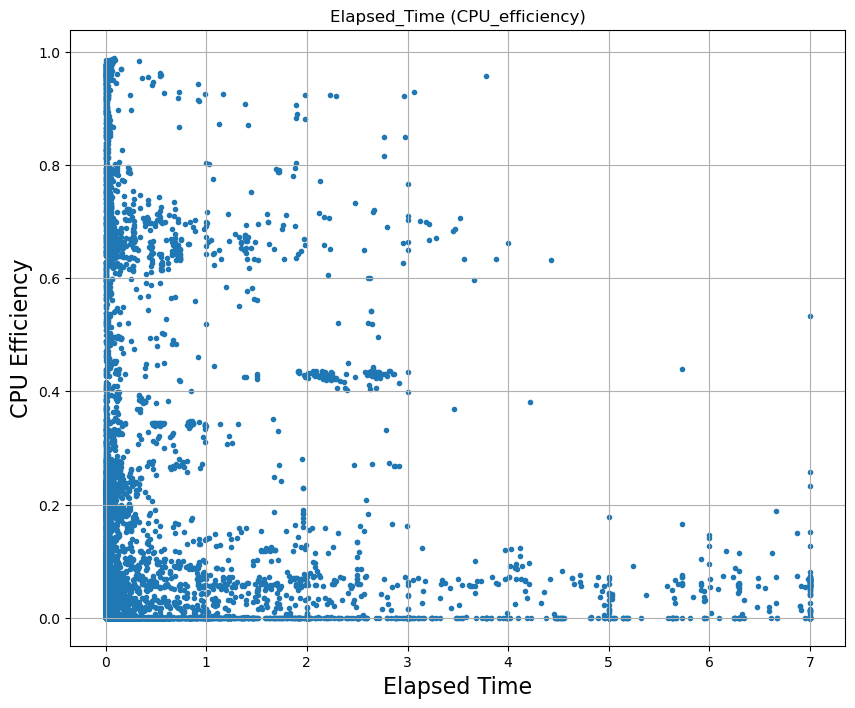

In [17]:
# TODO: Add second figure; plot(elapsed, efficiency, marker='o', ls='')
# CDF of job lengths
fg = plt.figure(figsize=(10,8))
ax1 = fg.add_subplot(1,1,1)
#ax2 = ax1.twiny()
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')
# #
#ax1.plot(sorted(gpu_jobs['Elapsed']), numpy.arange(1,len(gpu_jobs)+1), lw=3)
#hh = ax1.hist(gpu_jobs['Elapsed'], bins=100, cumulative=False, density=False, histtype='step',
#              lw=3, label='Elapsed')
cpu_efficiency = gpu_jobs['UserCPU']/(gpu_jobs['NCPUS']*gpu_jobs['Elapsed'])
#he = ax2.hist(cpu_efficiency, bins=100, cumulative=False, density=False, histtype='step',
#              lw=3, color='r', label='CPU Eff.')
ax1.scatter(gpu_jobs['Elapsed'], cpu_efficiency, marker='.')
ax1.set_title('Elapsed_Time (CPU_efficiency)')
ax1.set_ylabel('CPU Efficiency', size=16)
ax1.set_xlabel('Elapsed Time', size=16)
#
#ax1.set_xlabel('Time (days)', size=16)
#ax1.set_ylabel('Count (or percentage)', size=16)
ax1.grid()
#ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')
#

/tmp/ipykernel_21095/769185934.py:13: RuntimeWarning: invalid value encountered in divide
  usr_cpu_eff = usr_gpu_jobs['UserCPU']/(usr_gpu_jobs['NCPUS']*usr_gpu_jobs['Elapsed'])
/tmp/ipykernel_21095/769185934.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fg = plt.figure(figsize=(12,8))


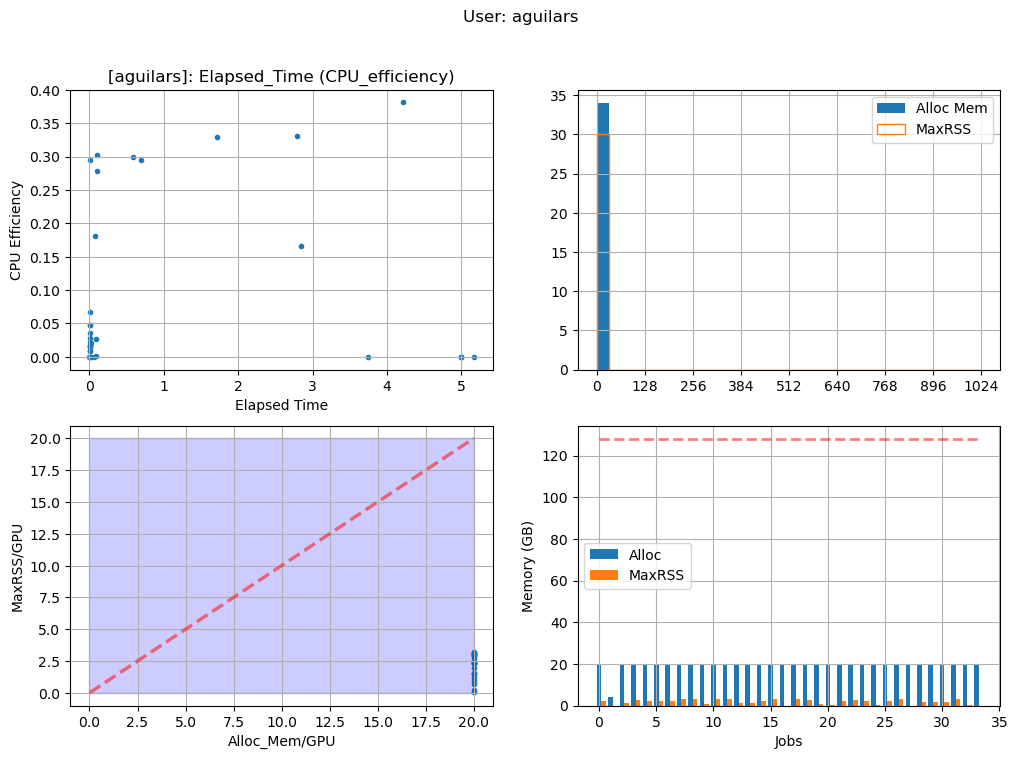

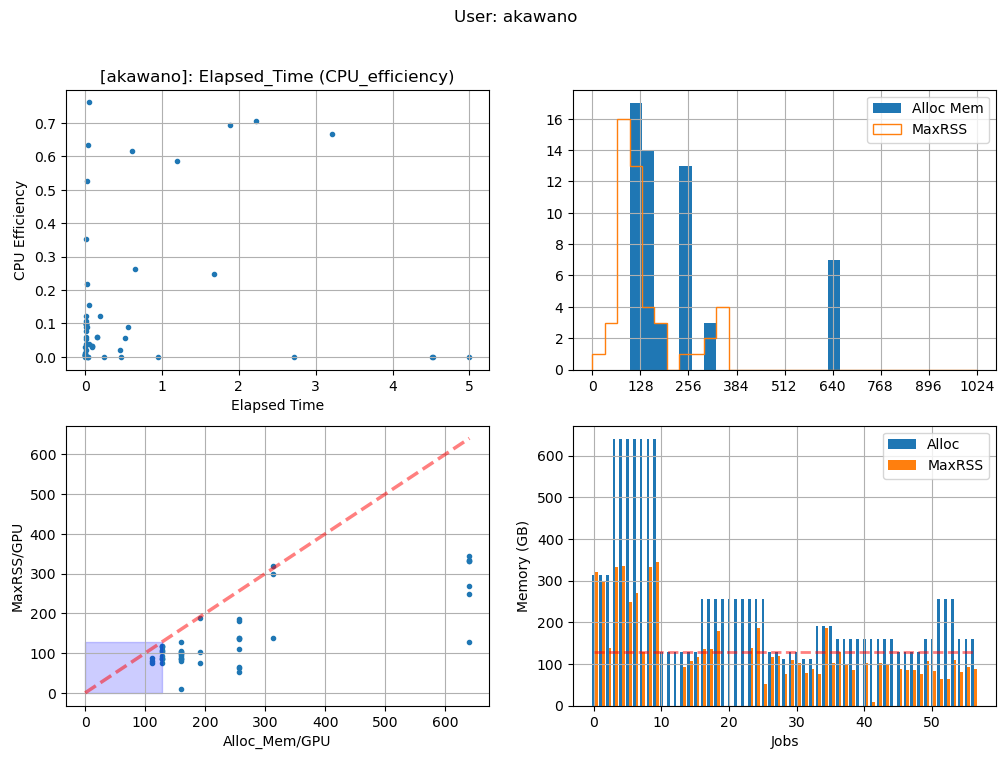

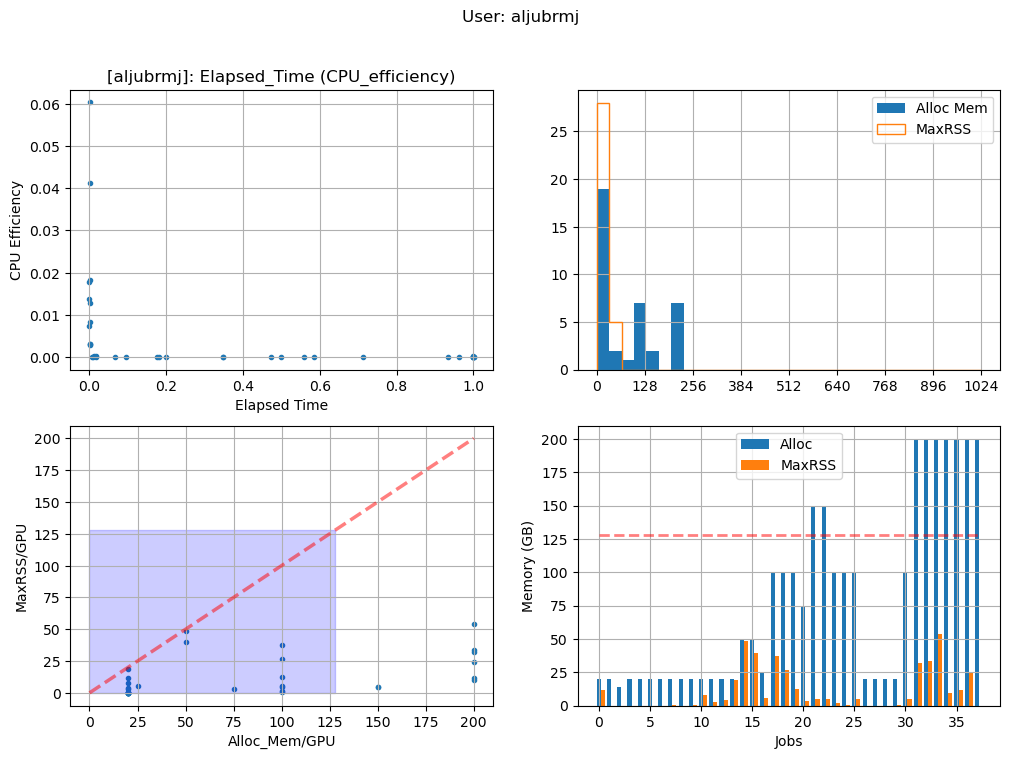

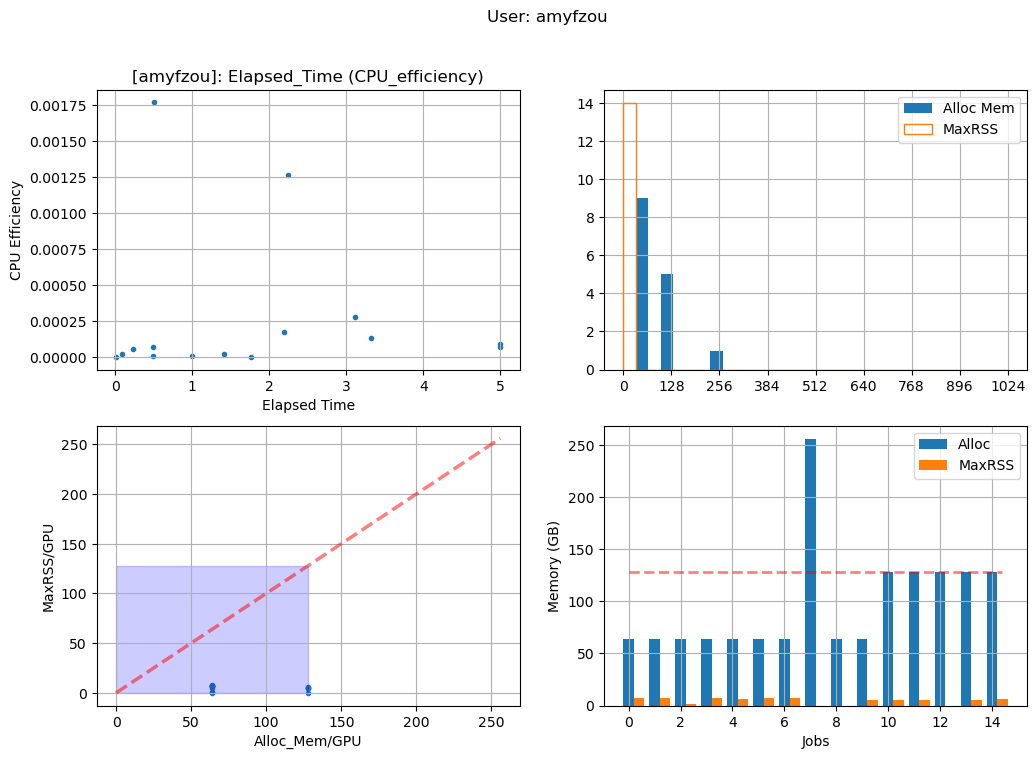

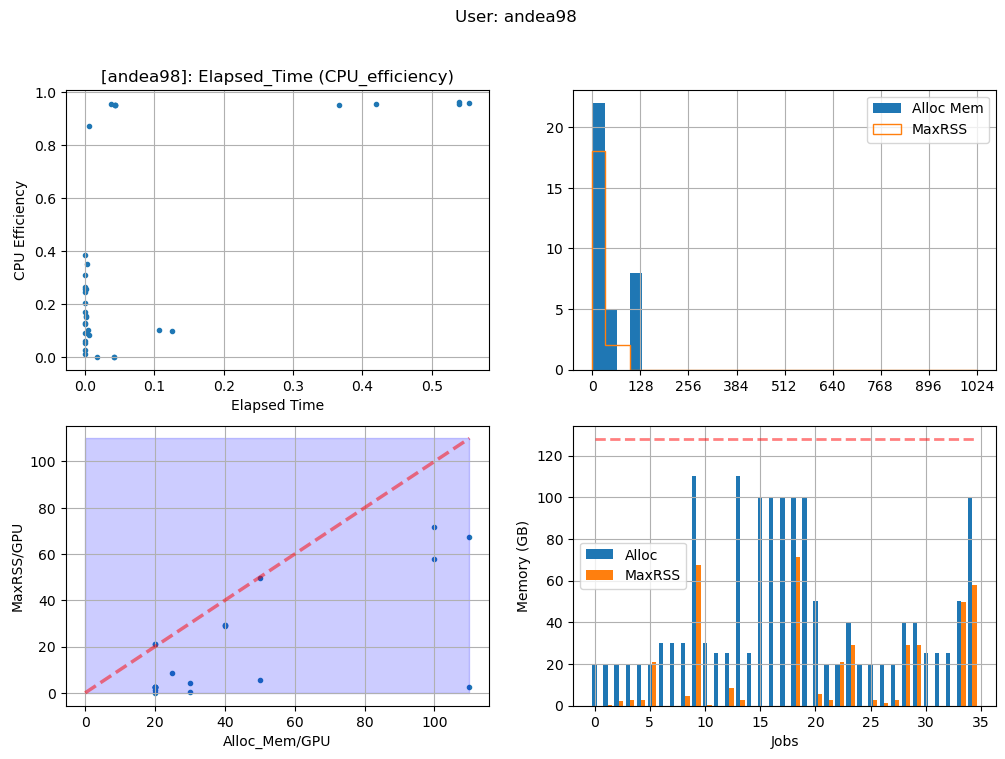

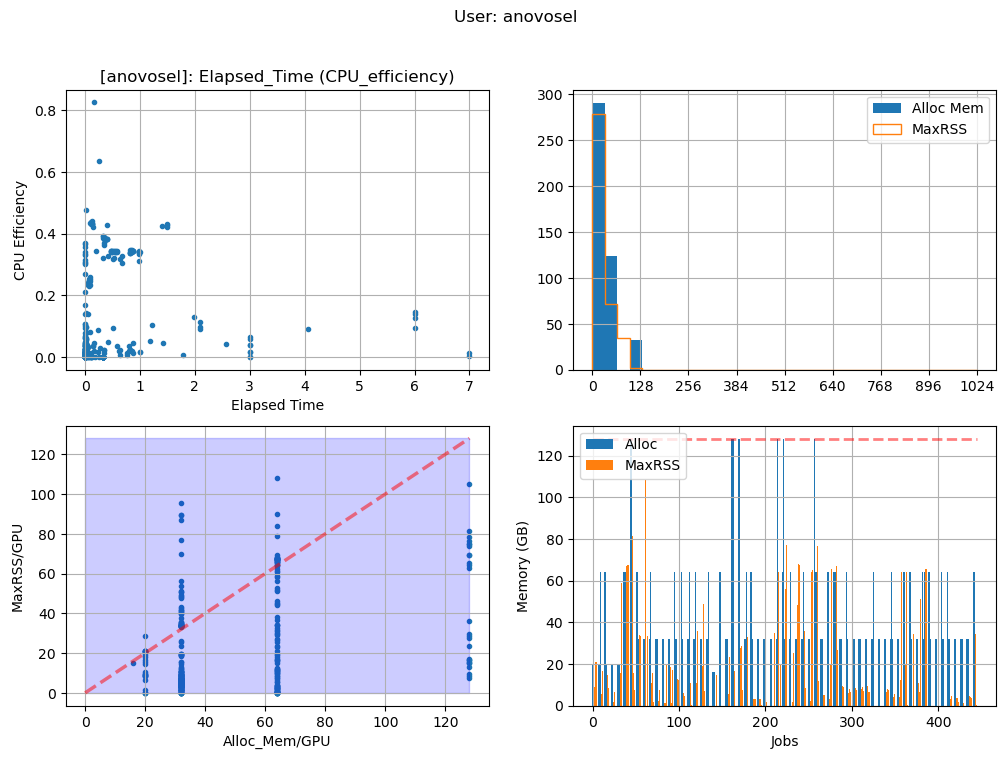

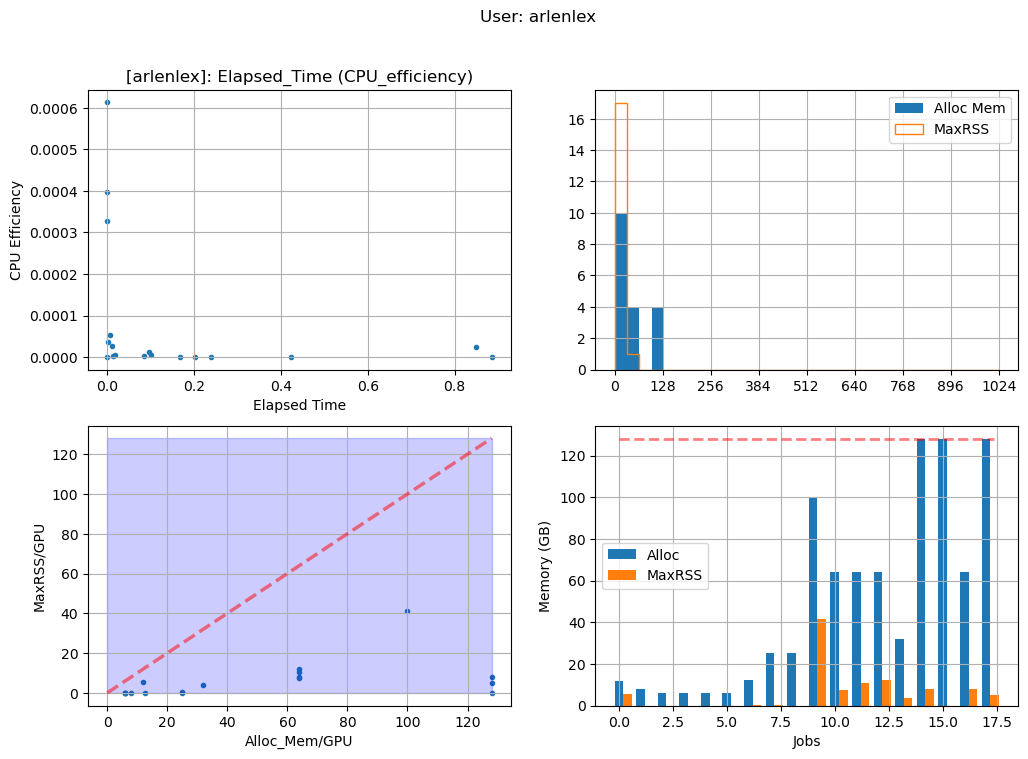

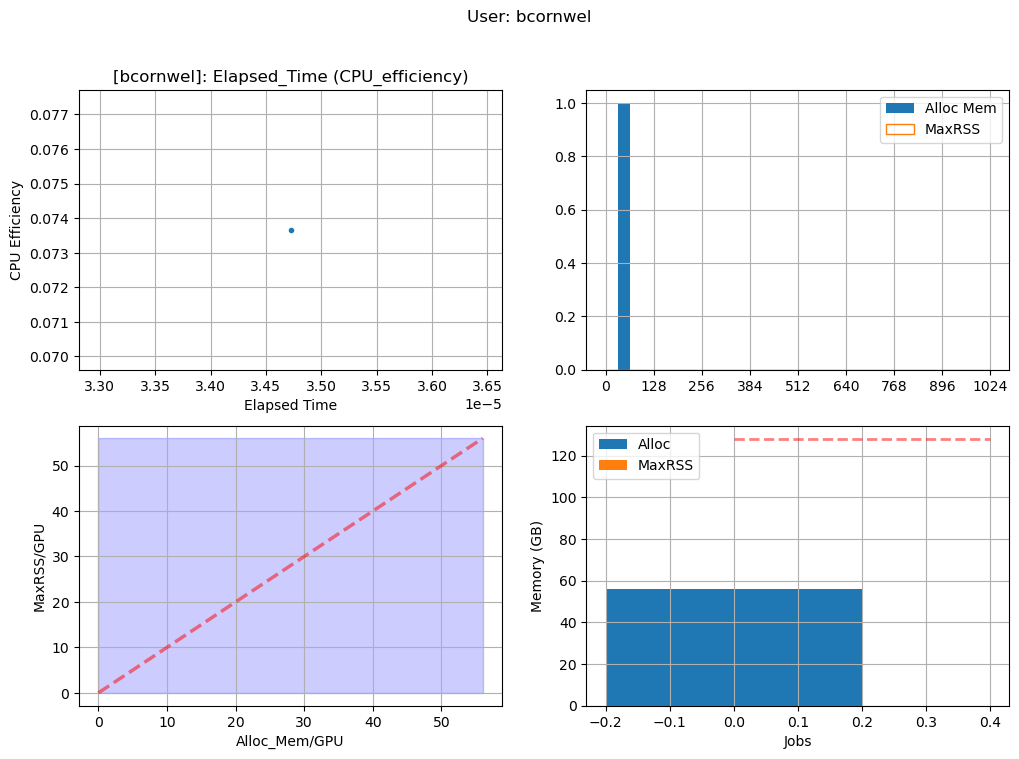

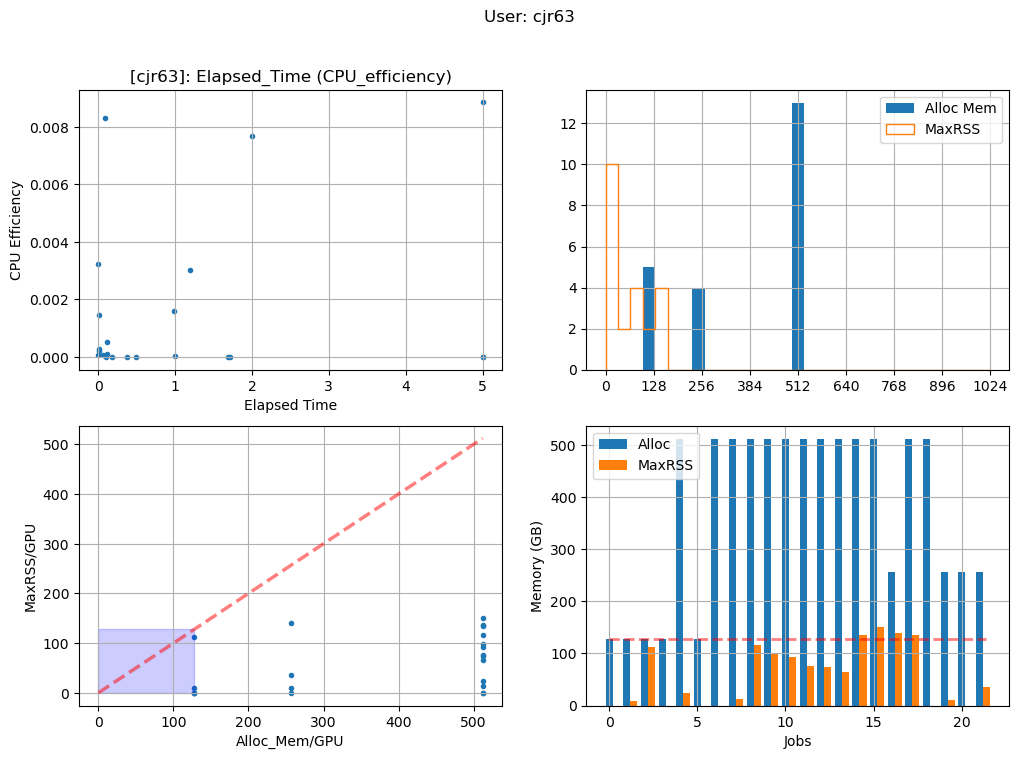

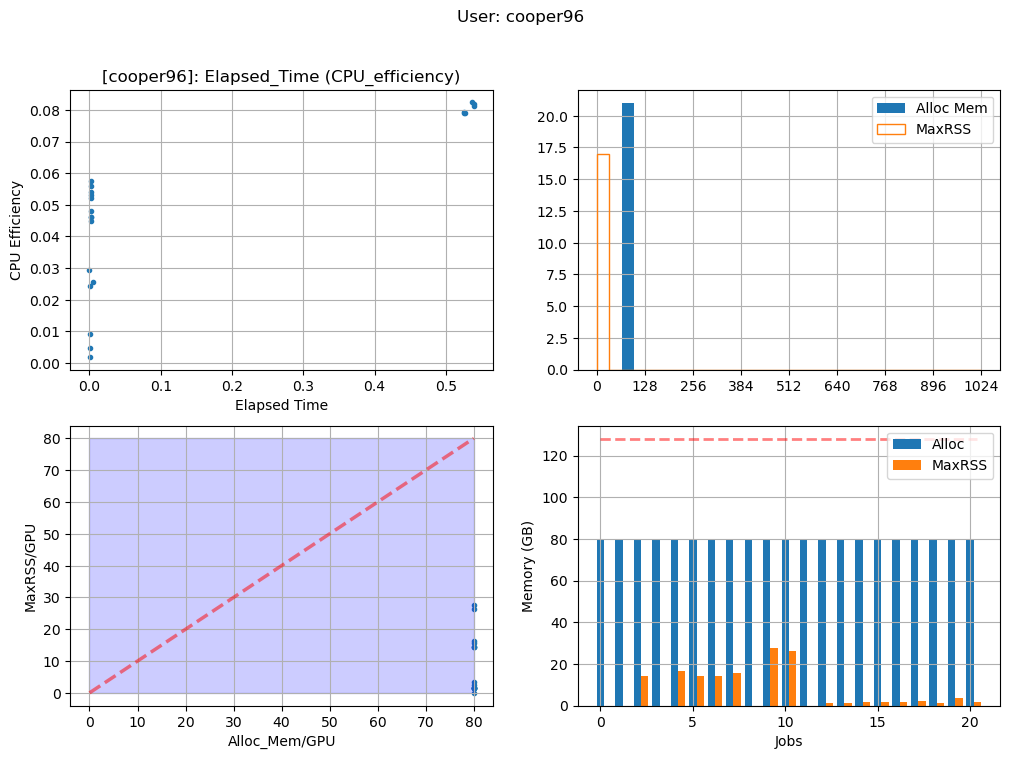

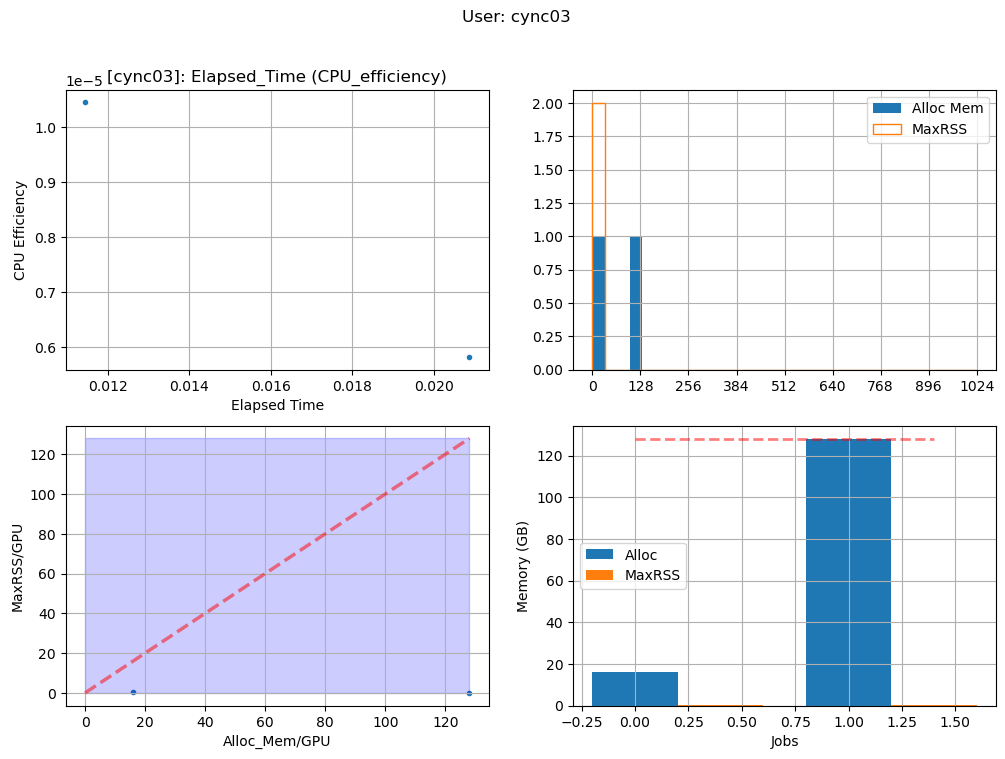

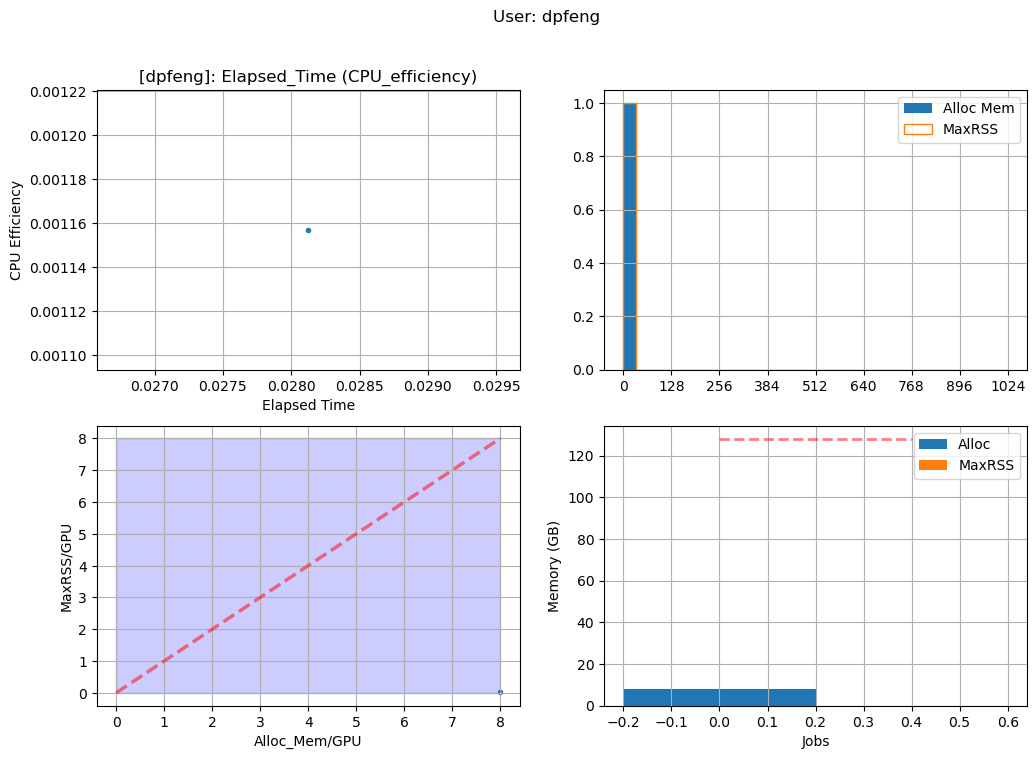

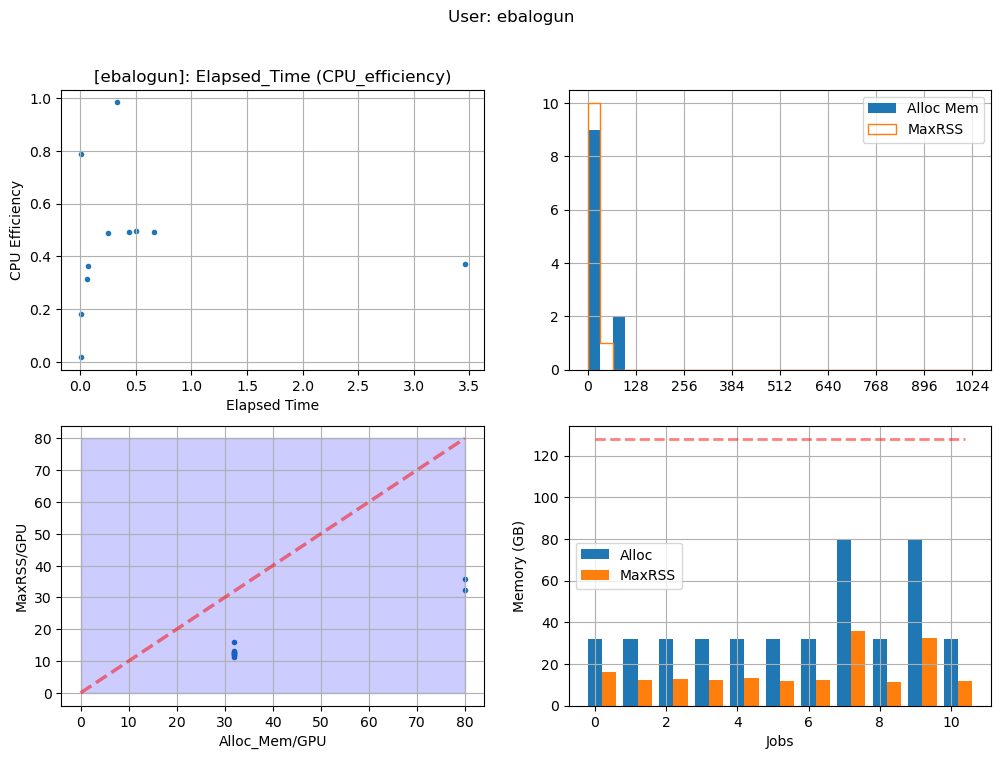

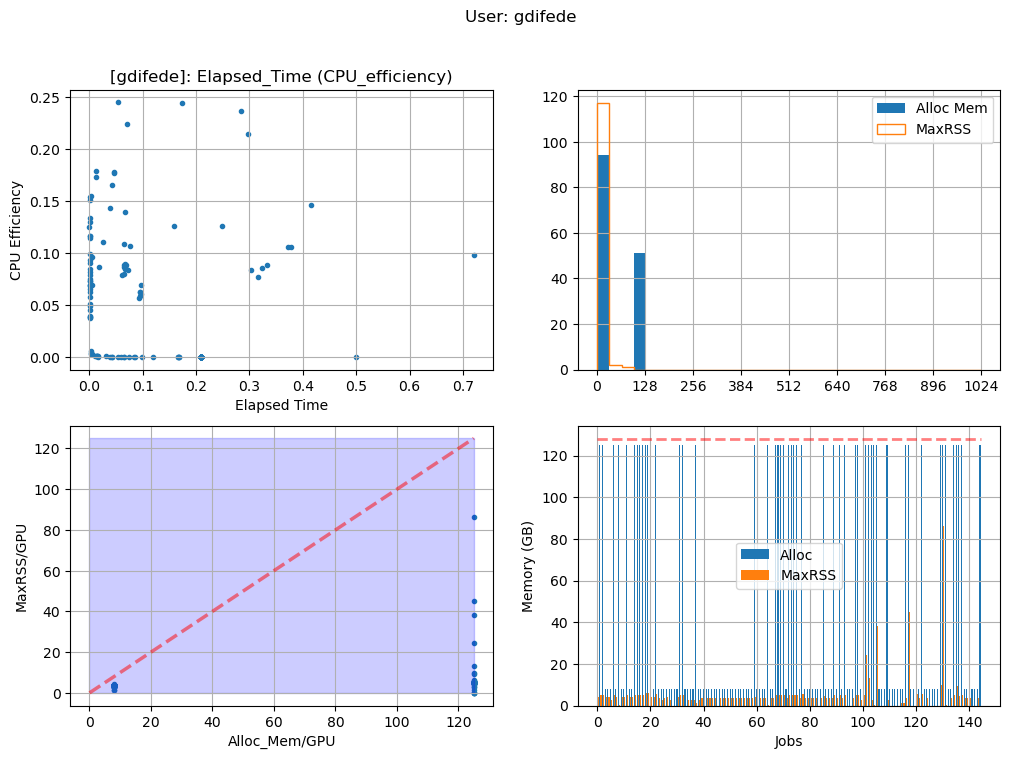

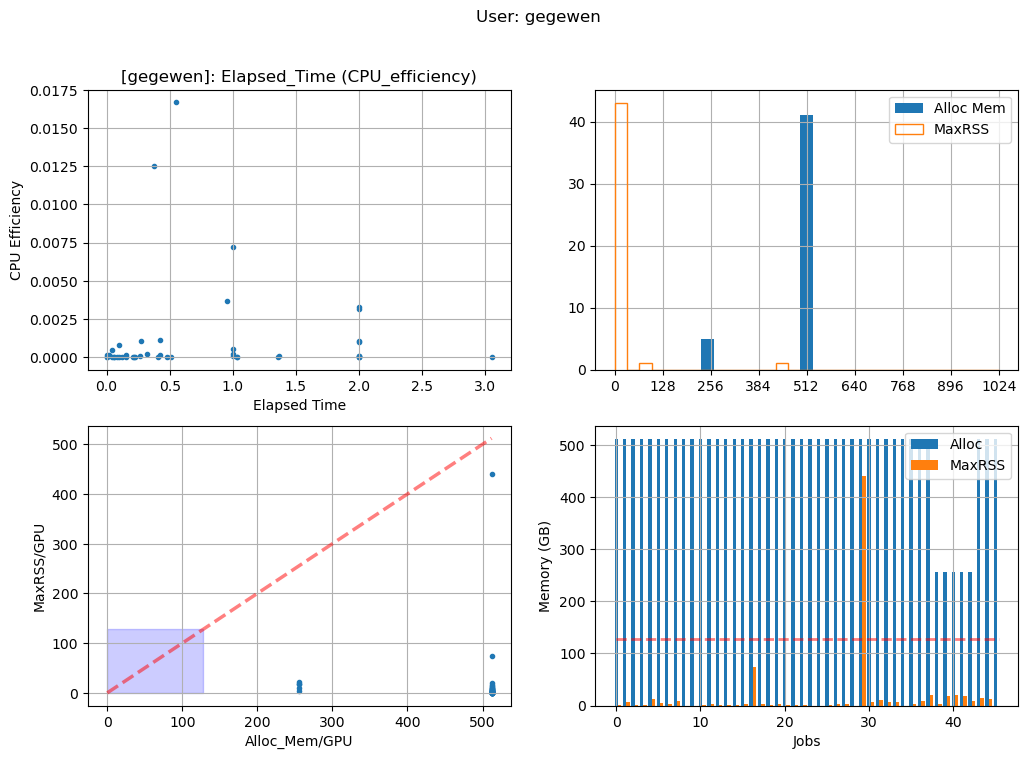

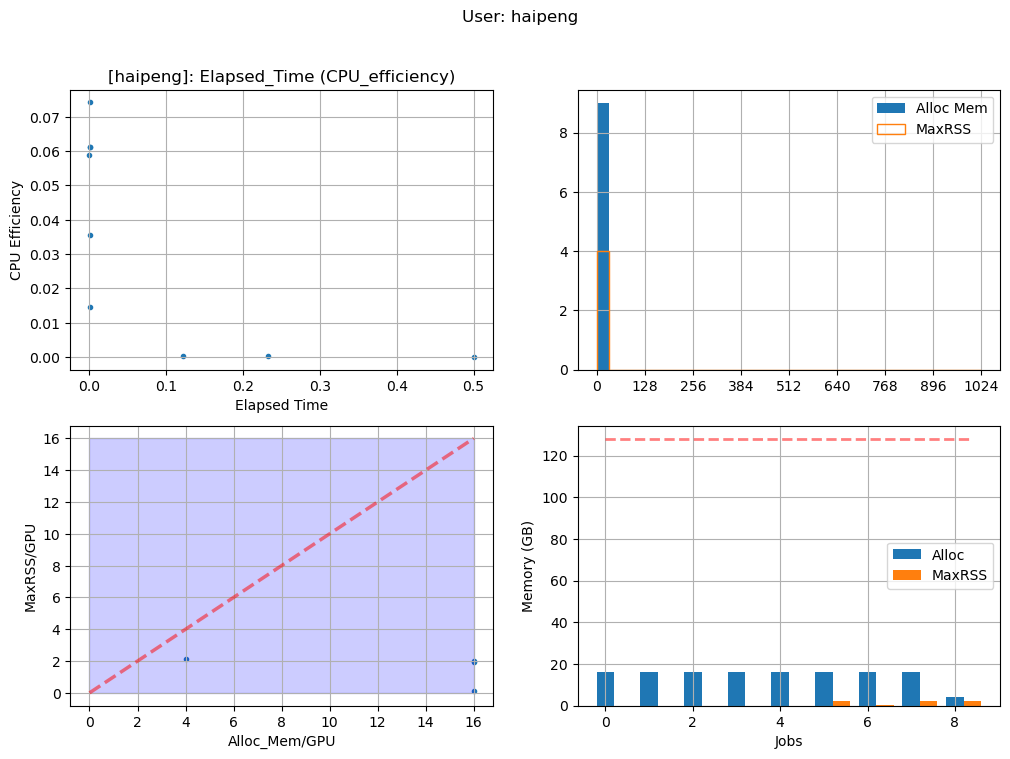

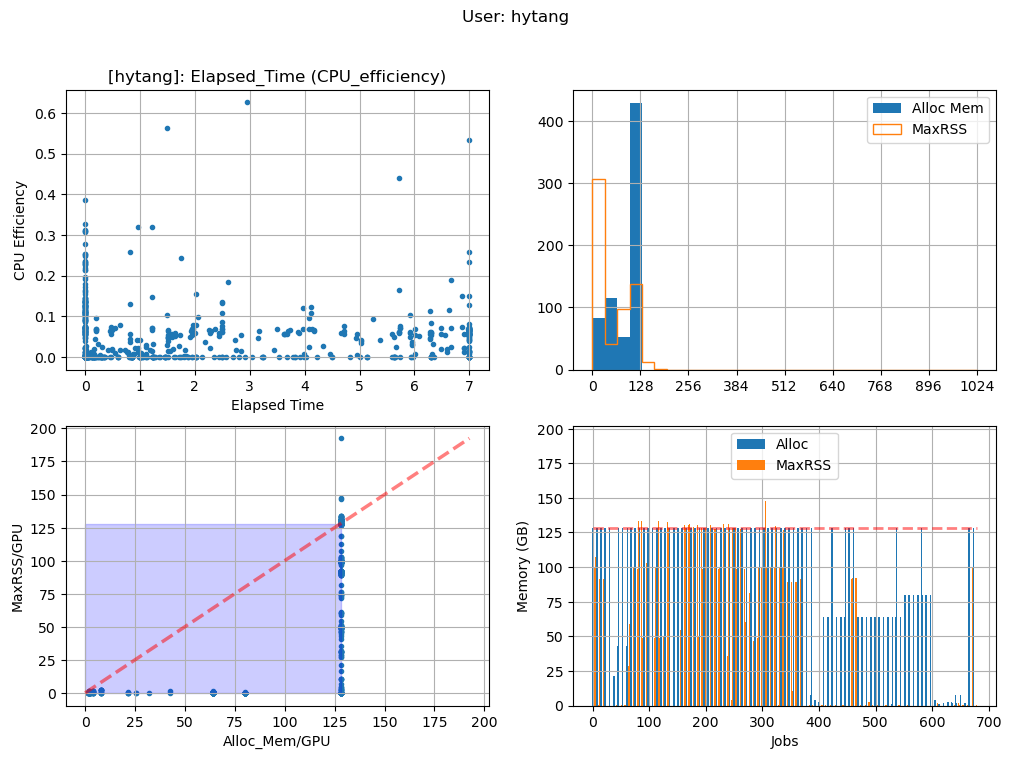

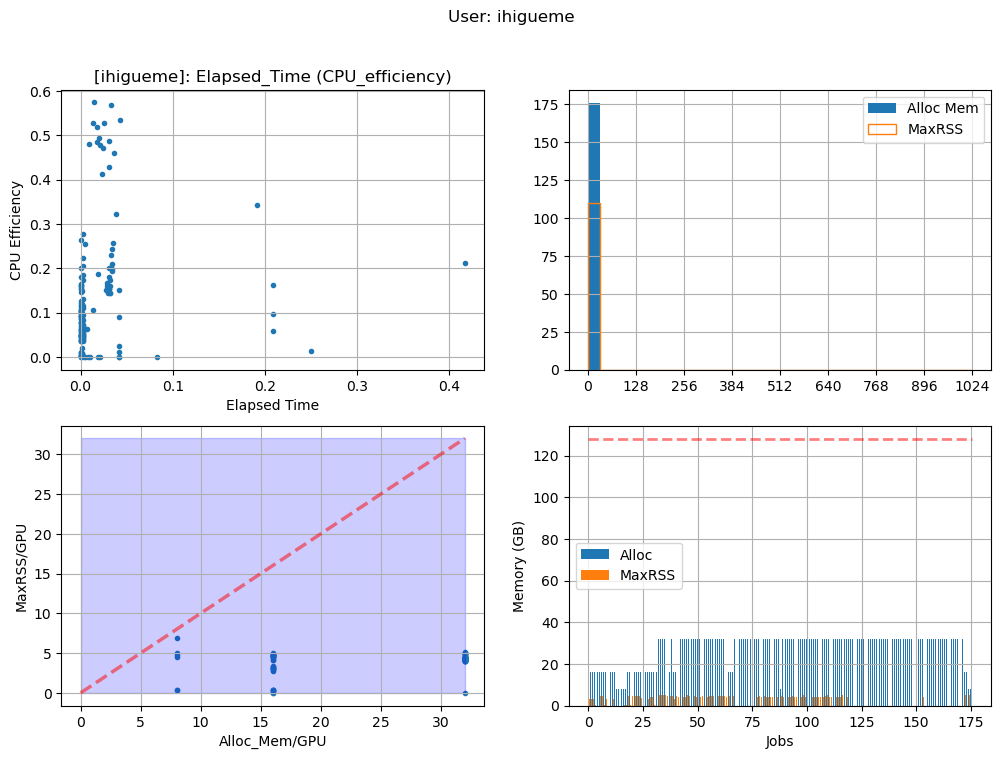

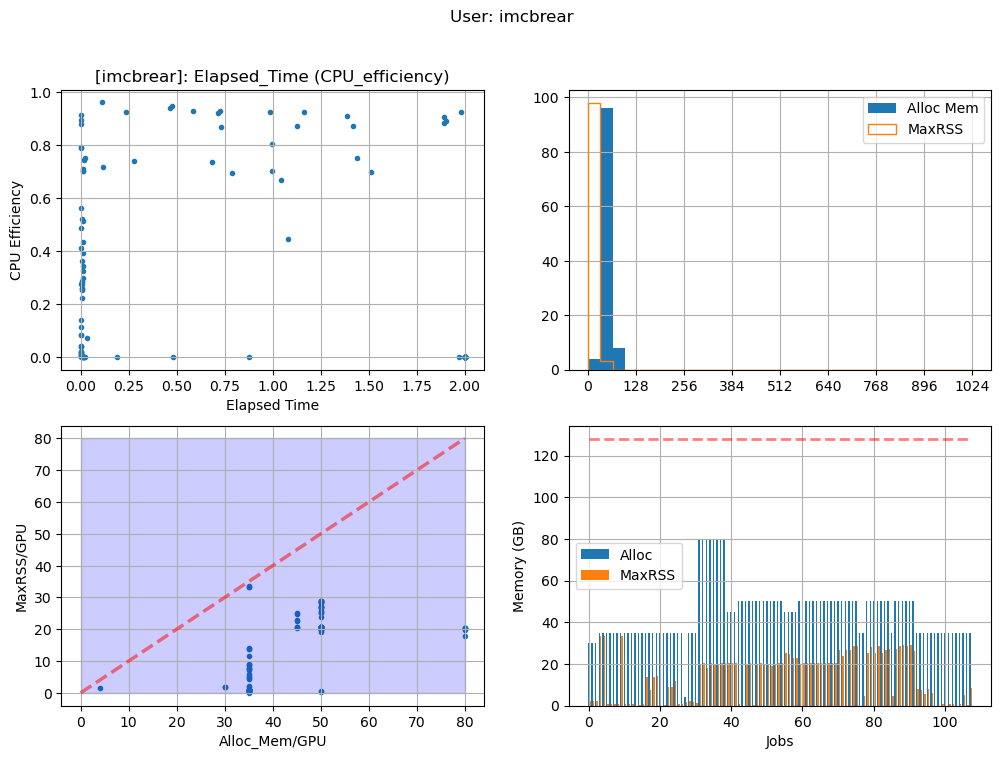

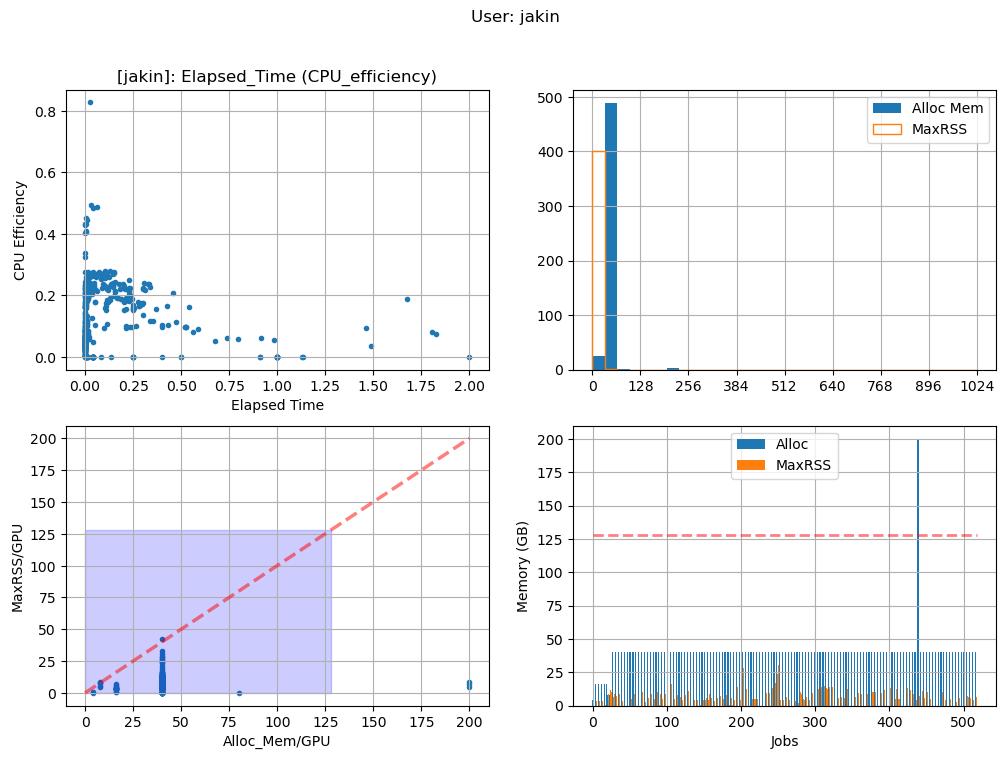

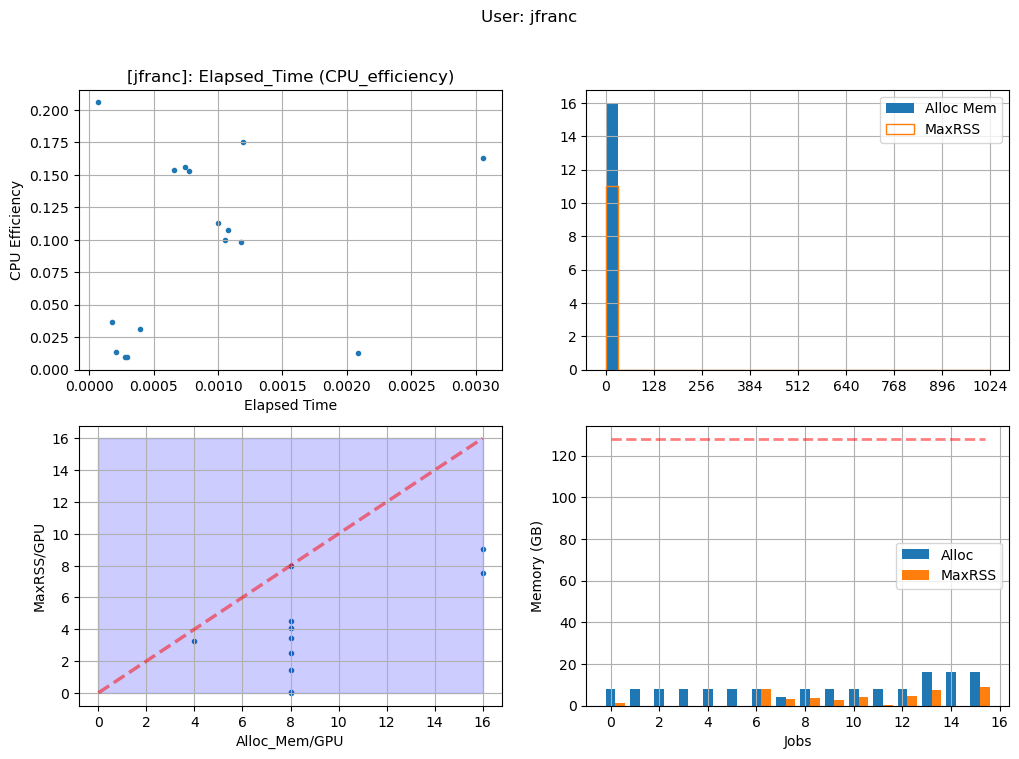

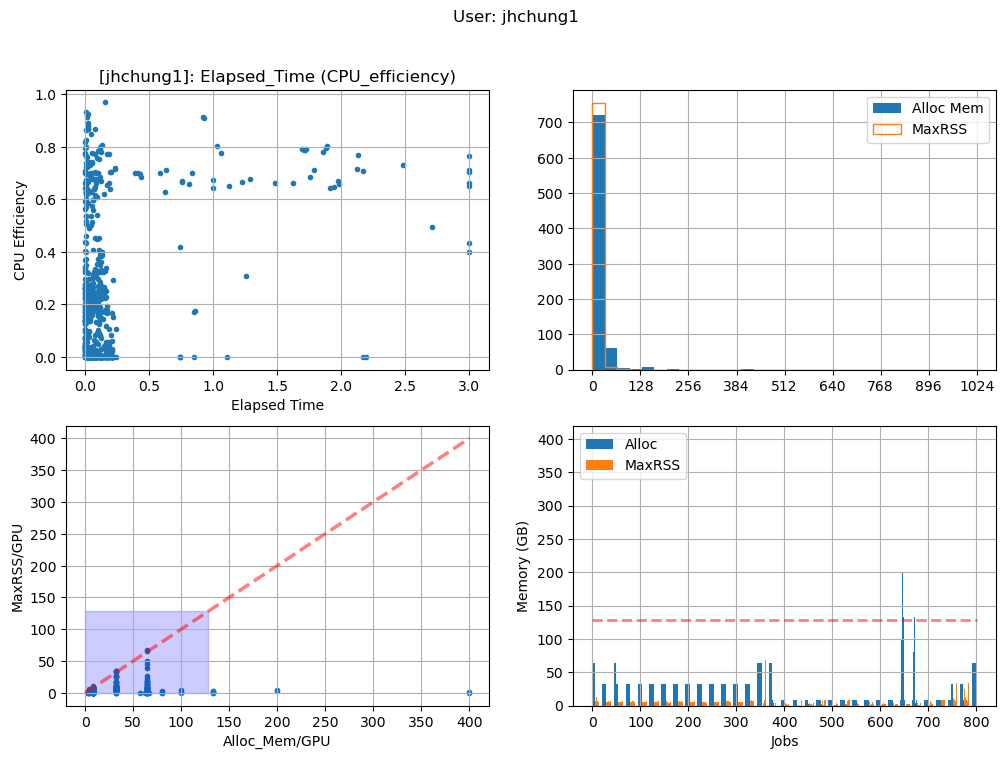

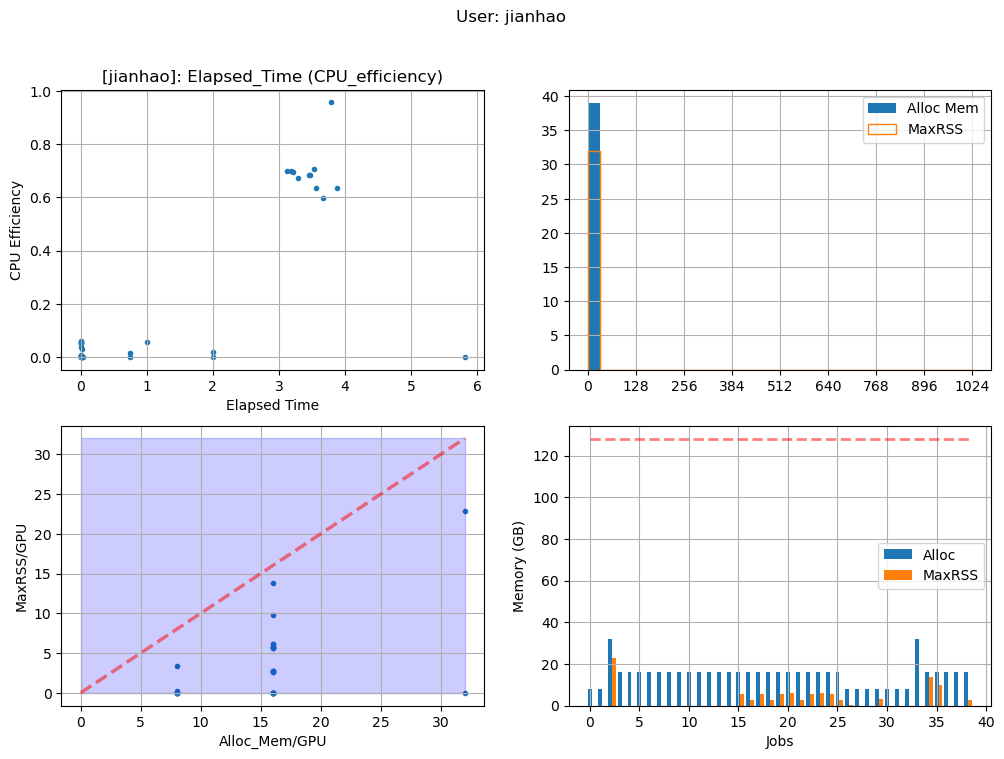

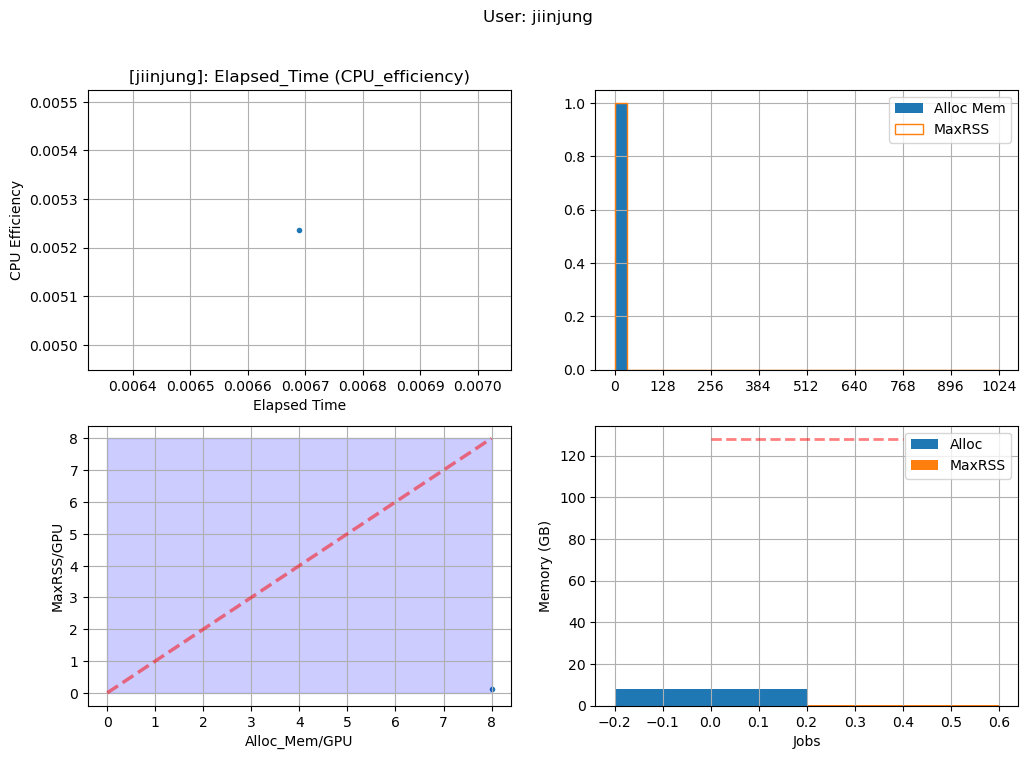

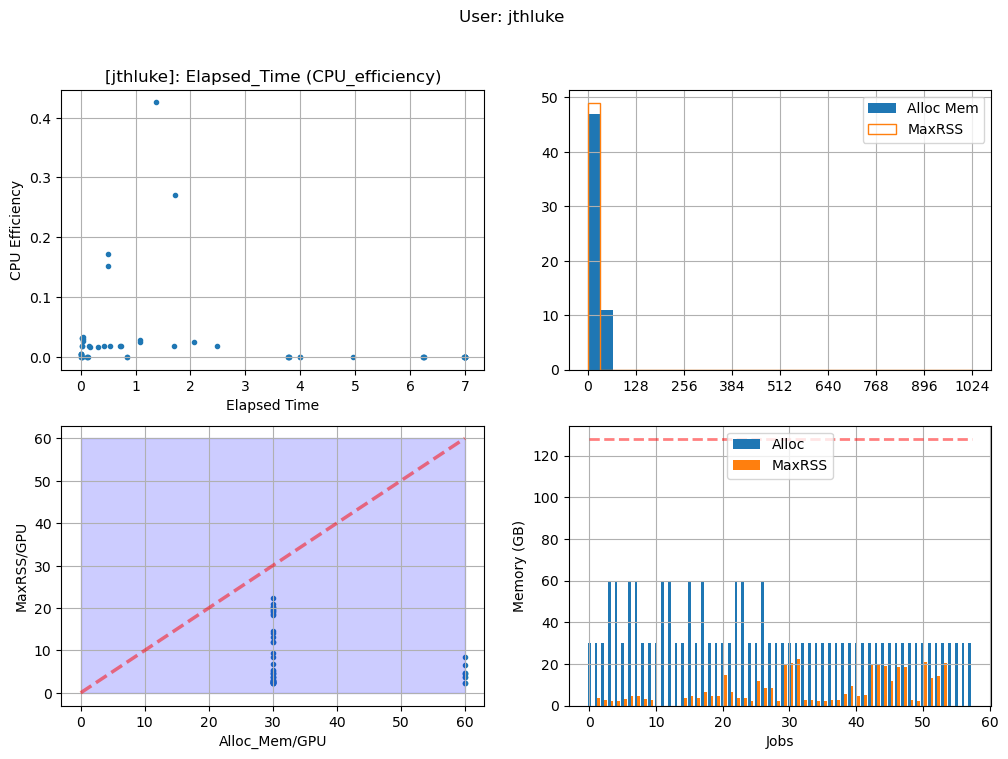

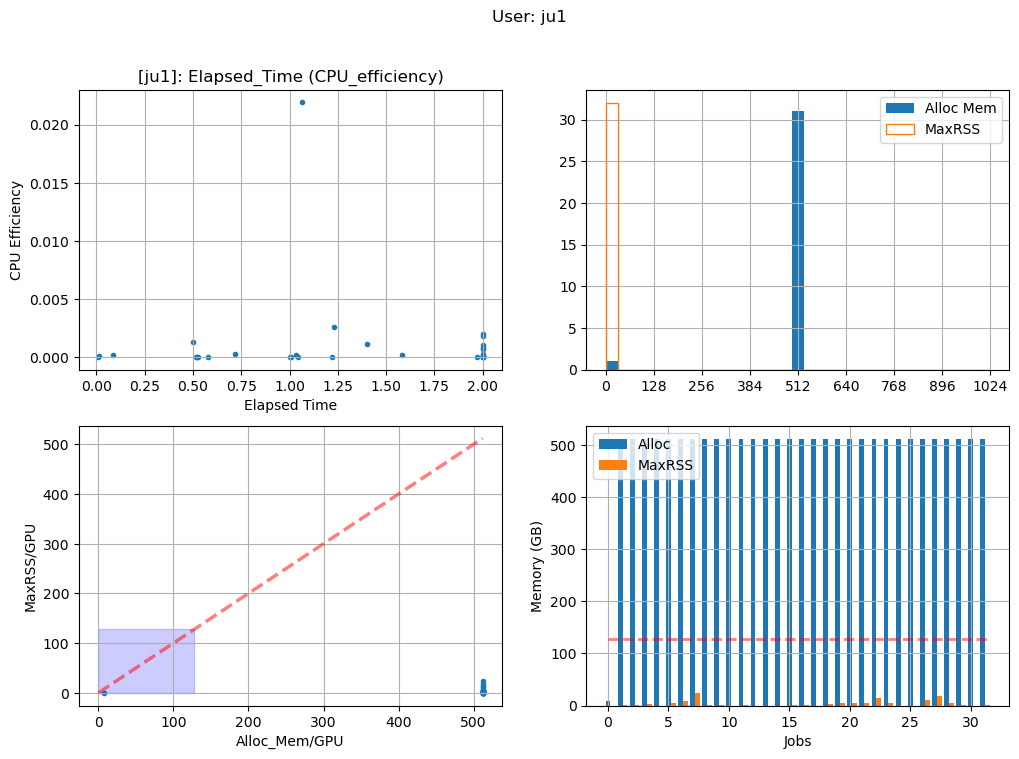

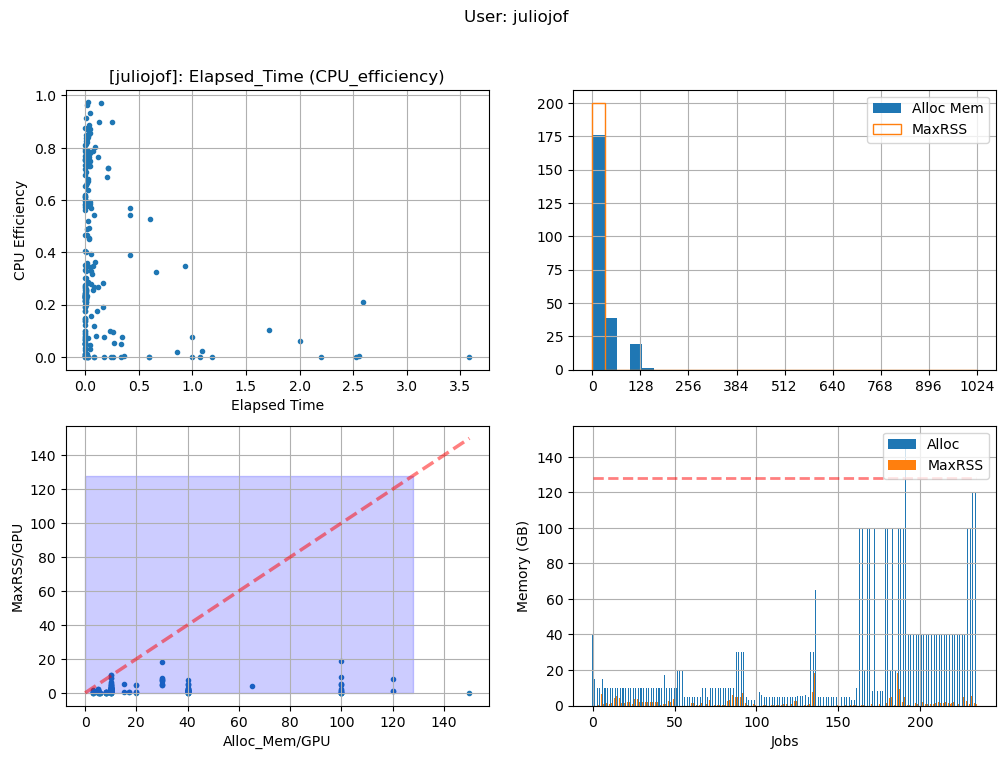

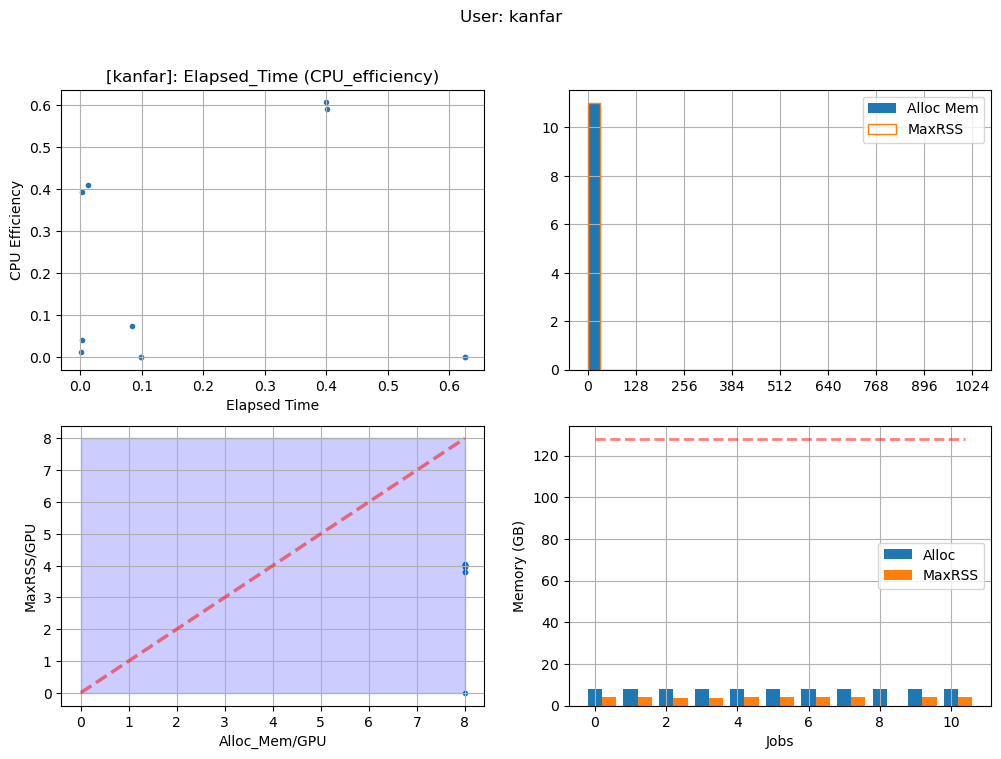

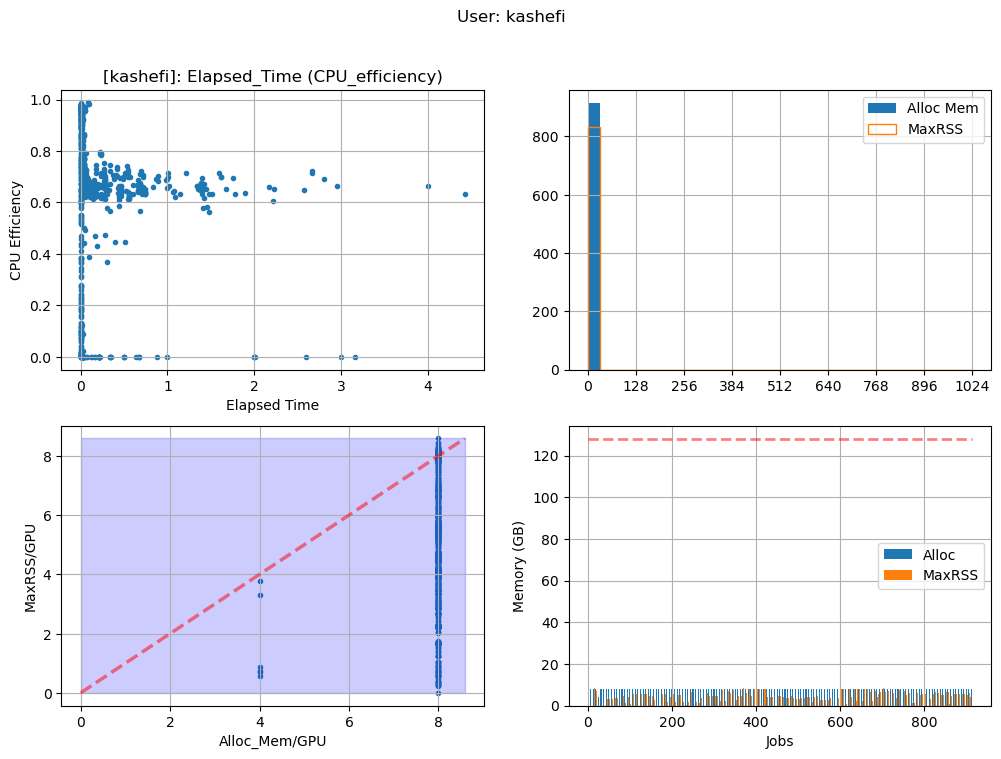

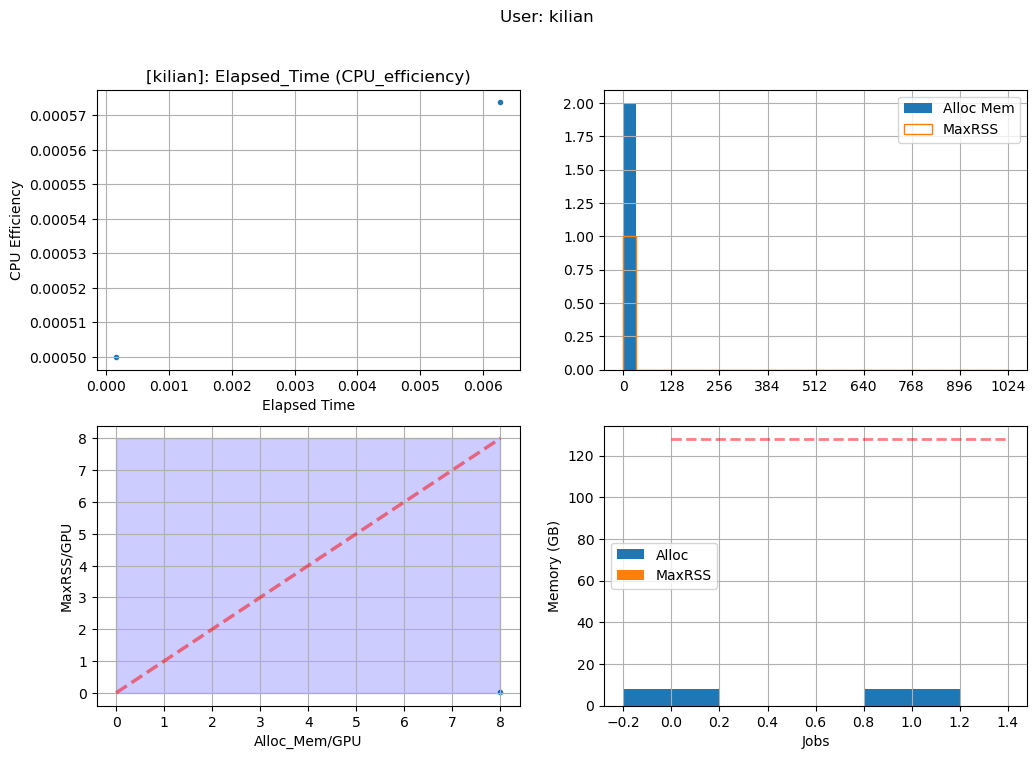

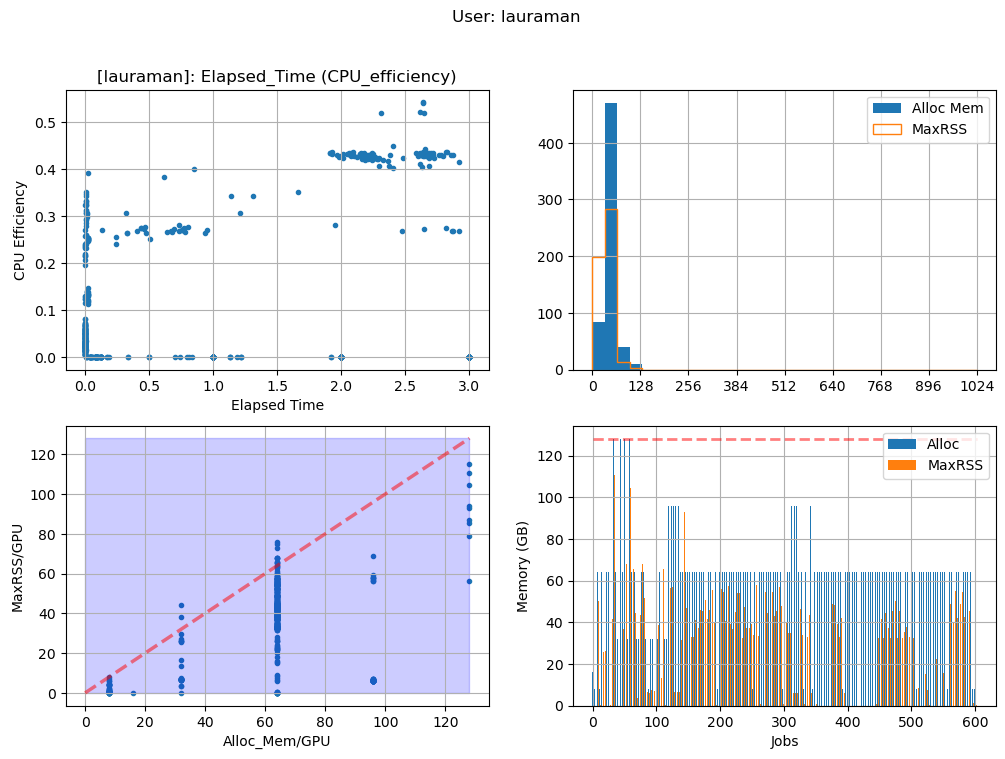

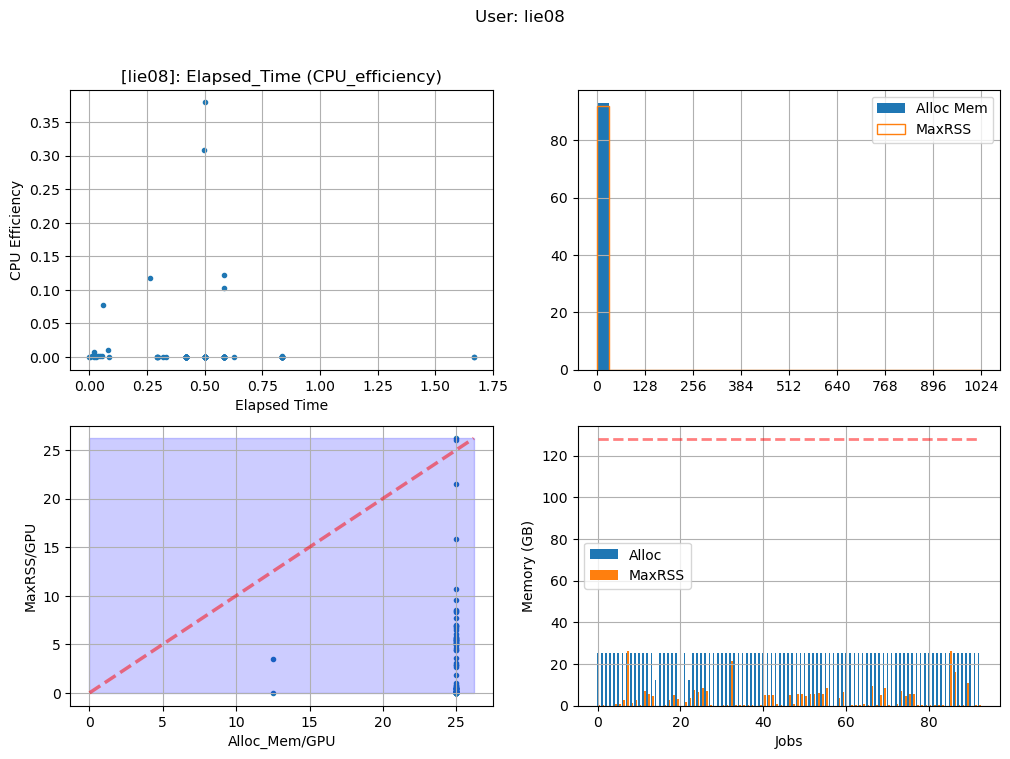

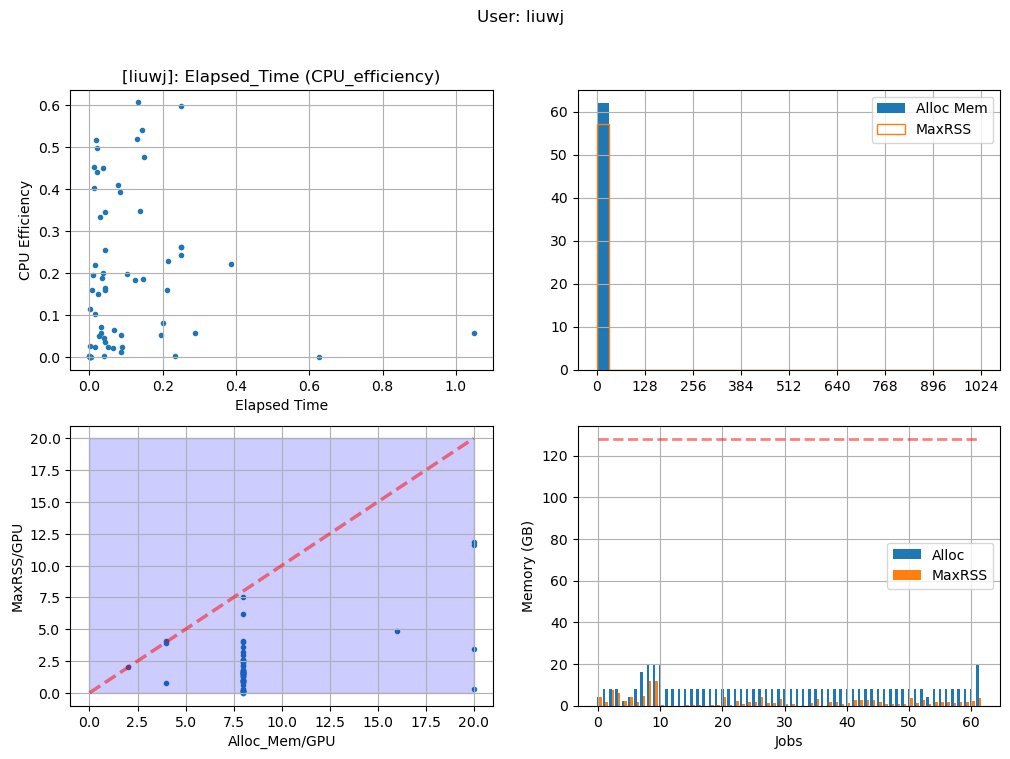

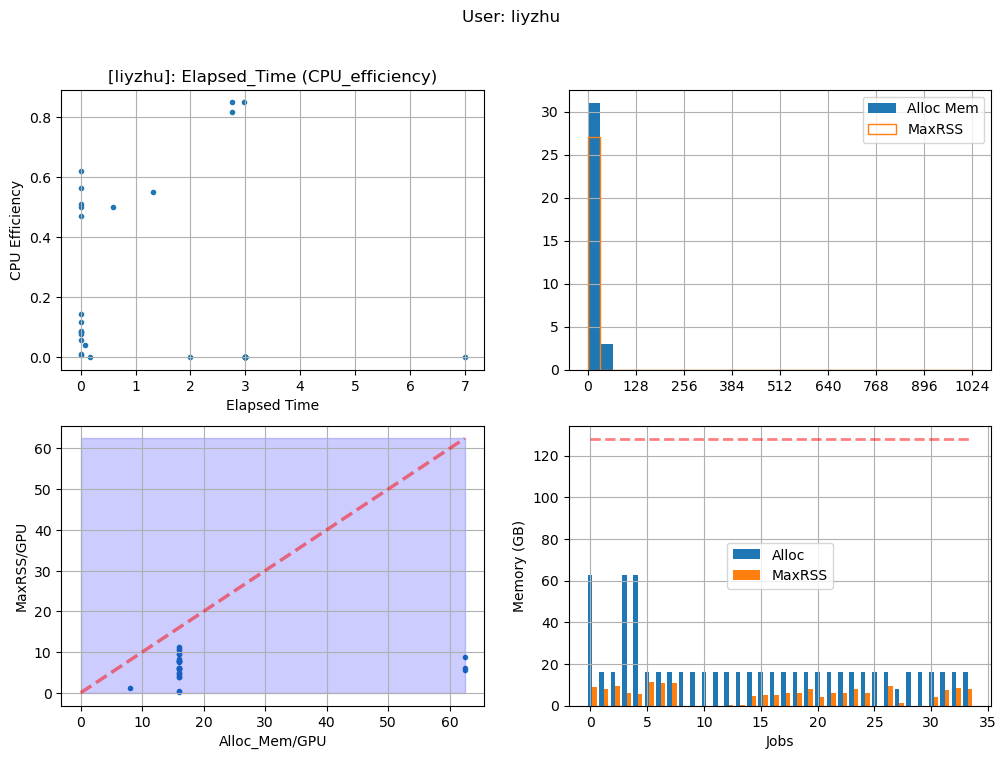

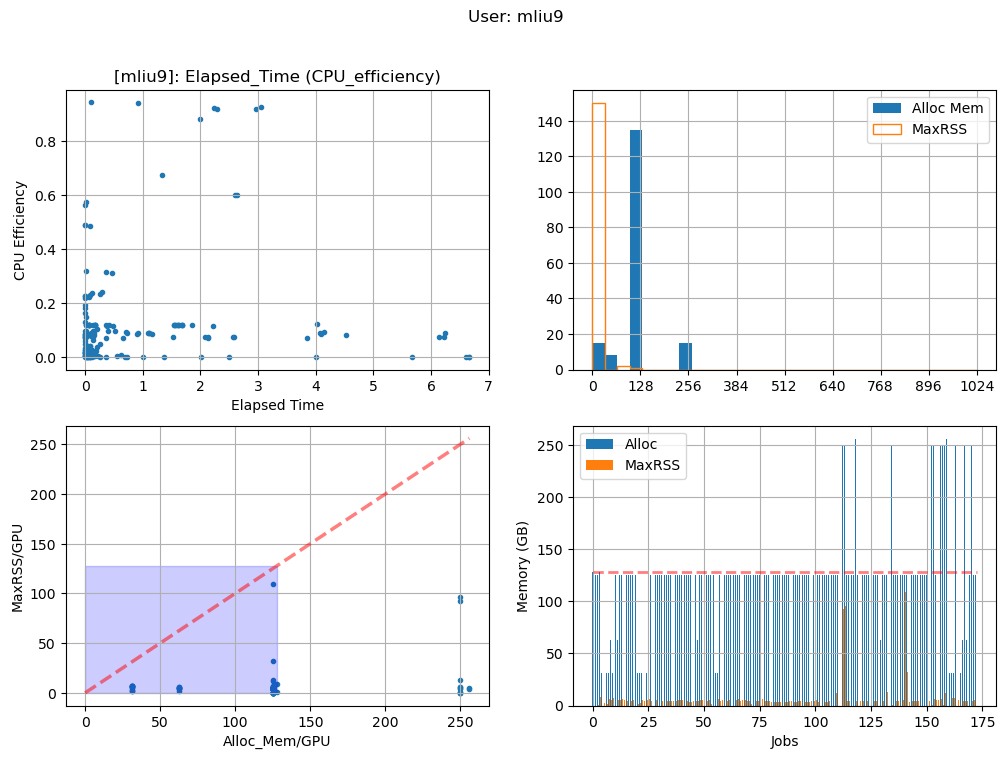

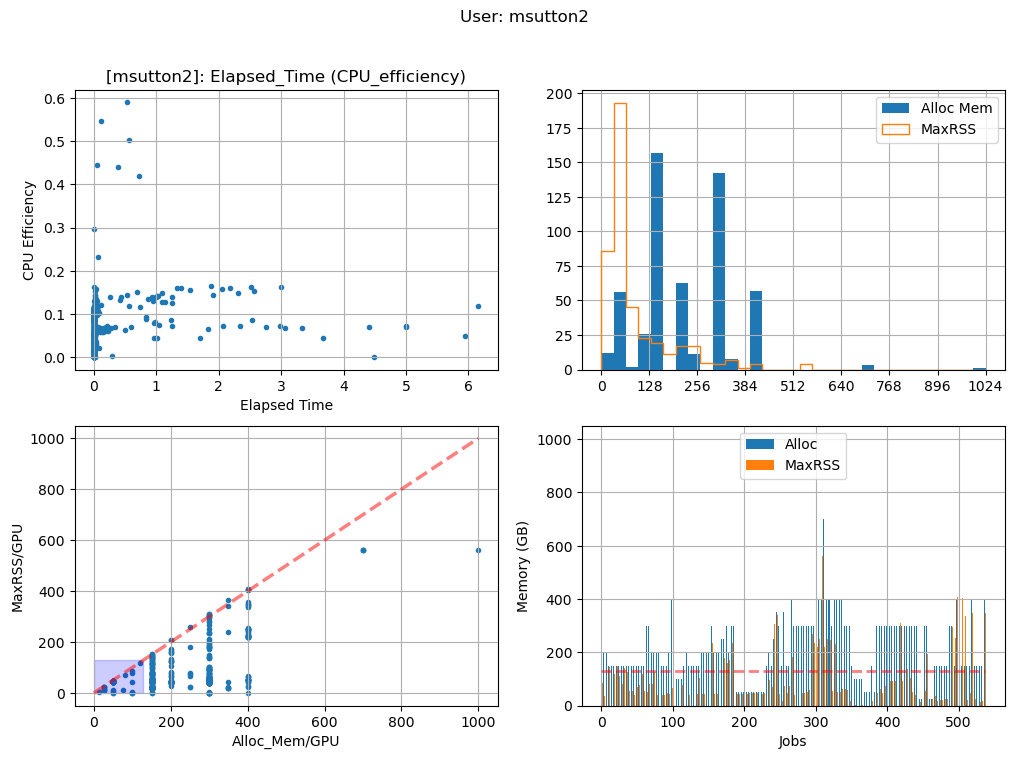

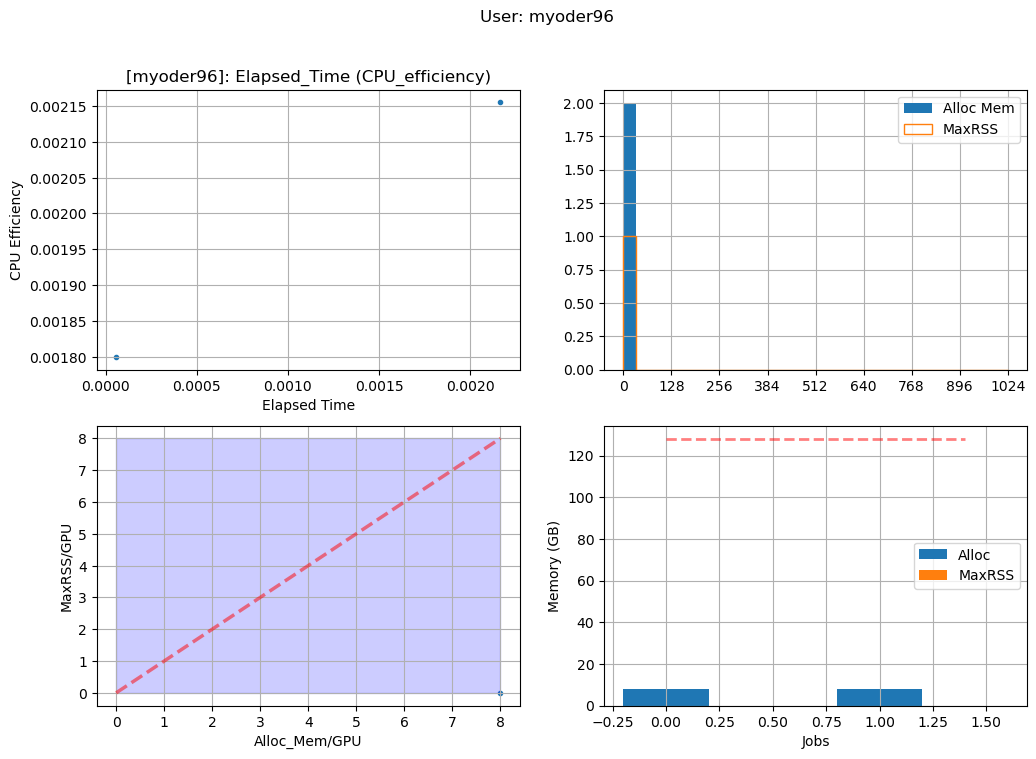

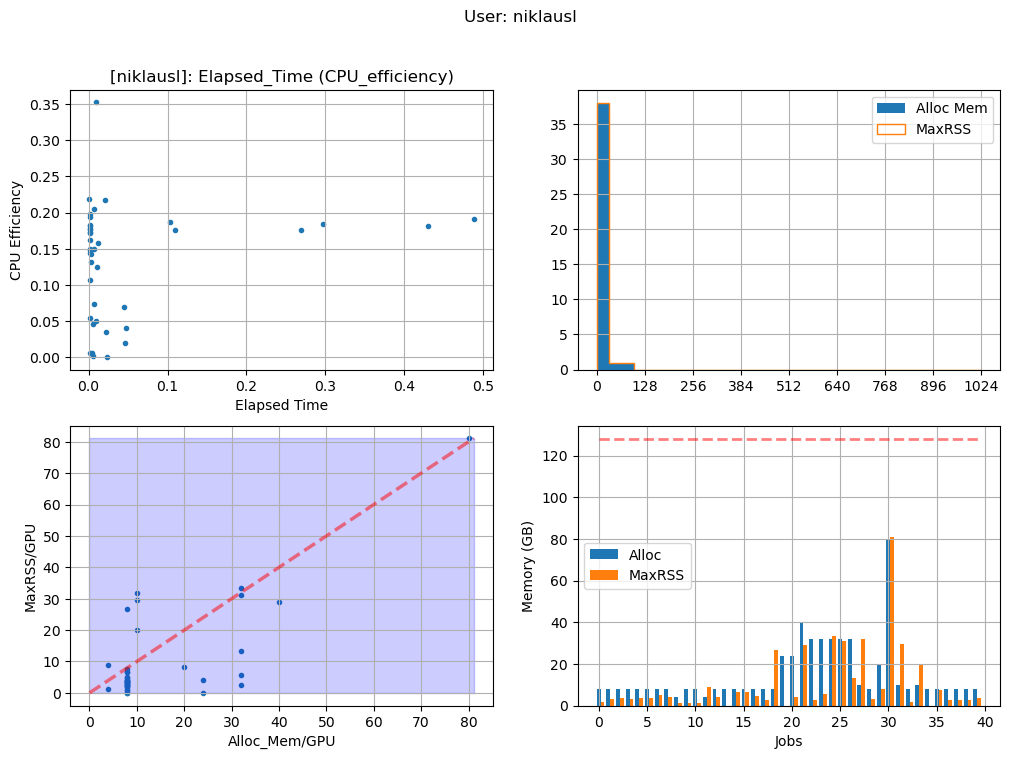

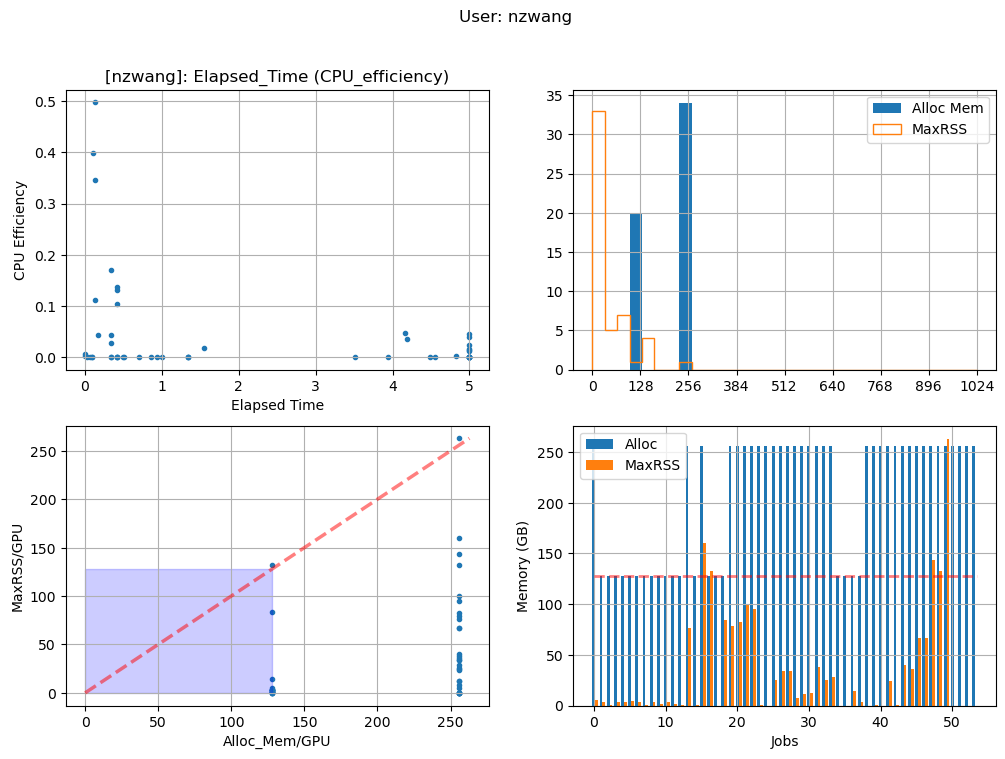

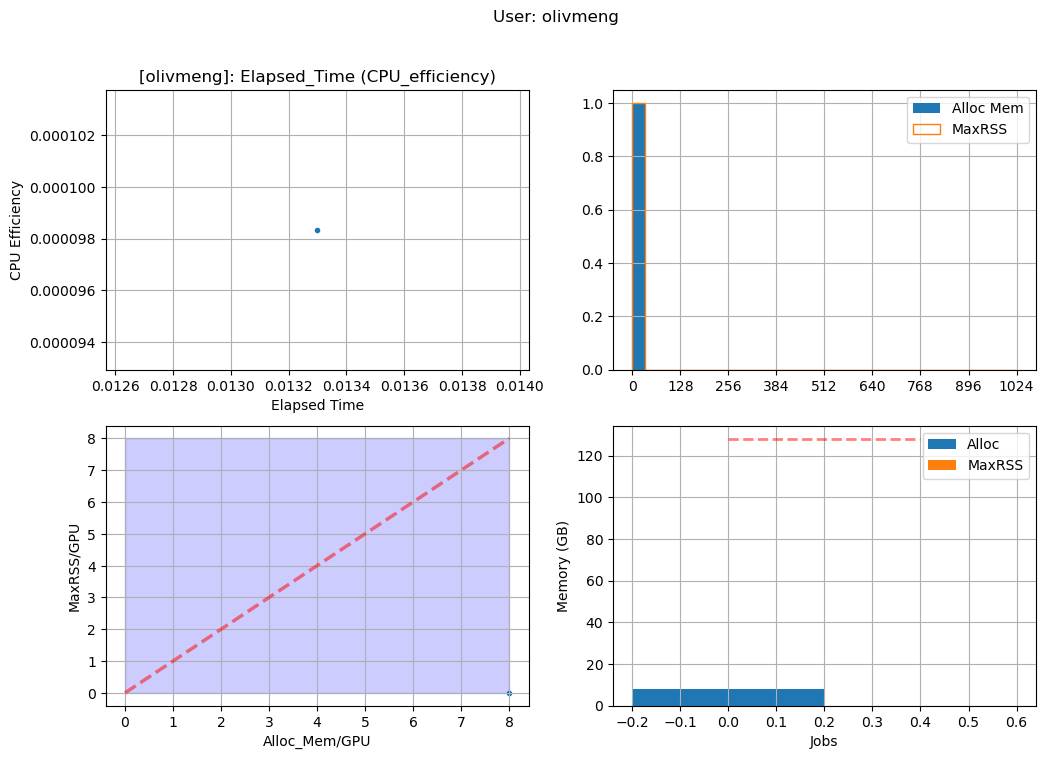

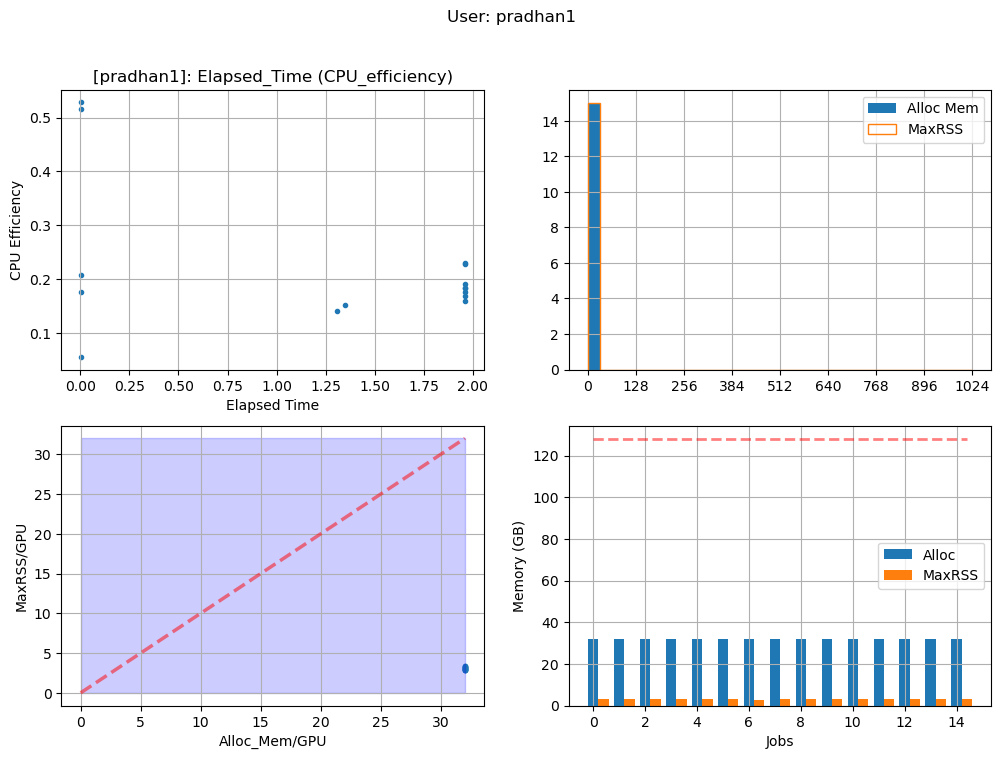

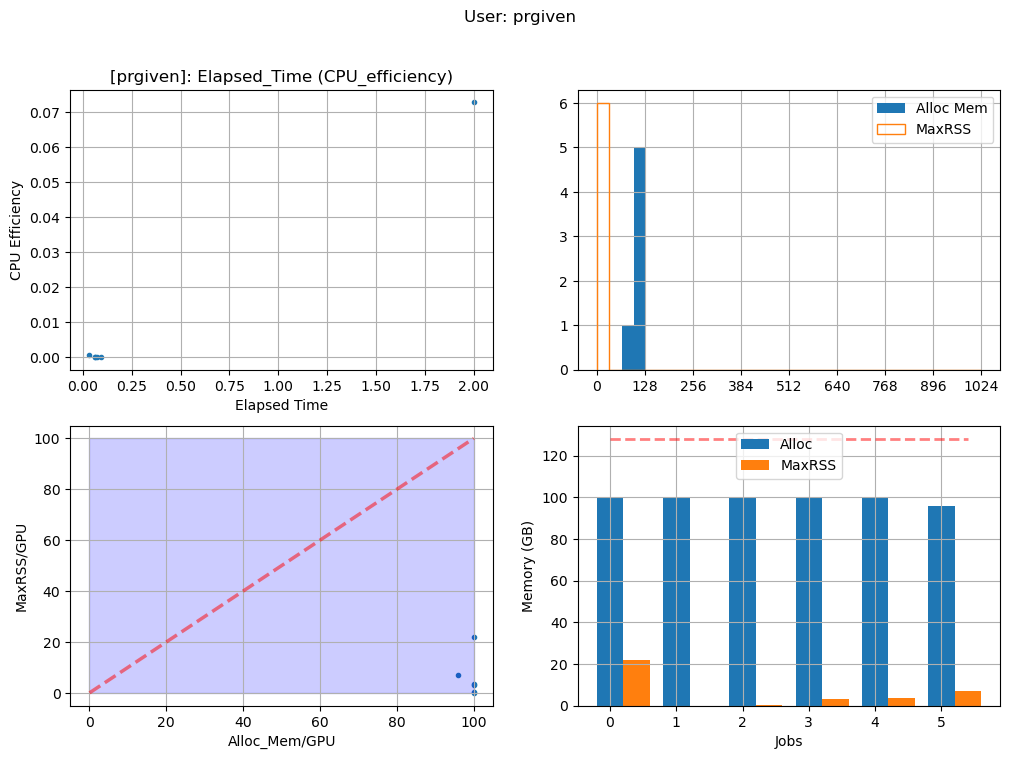

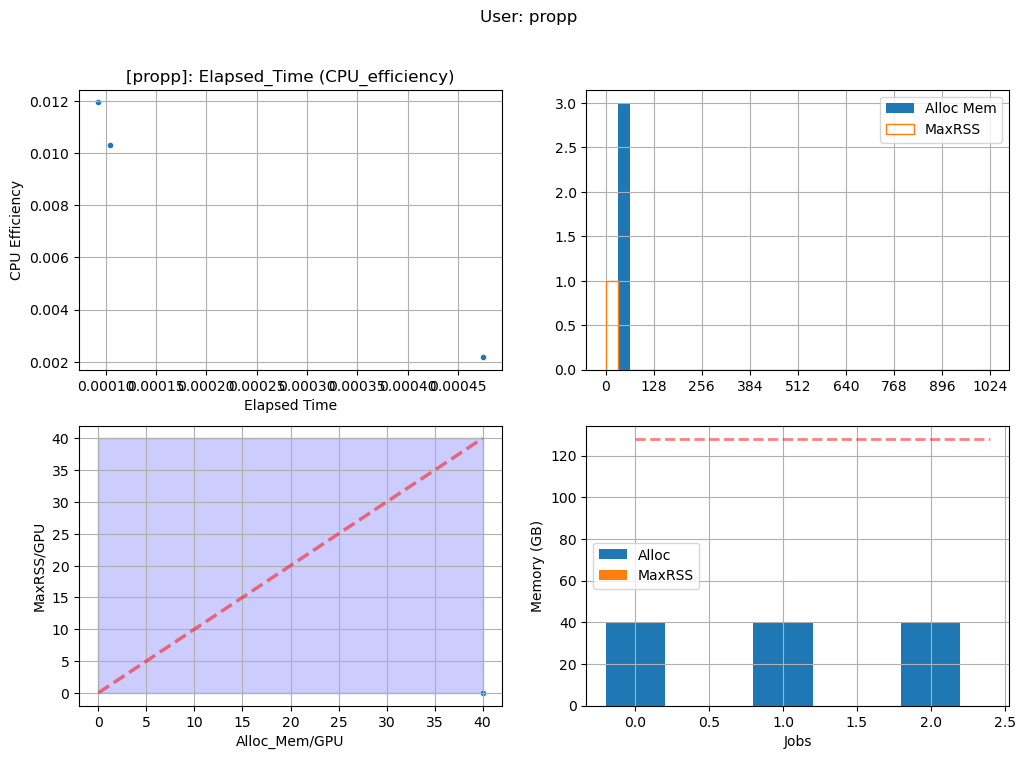

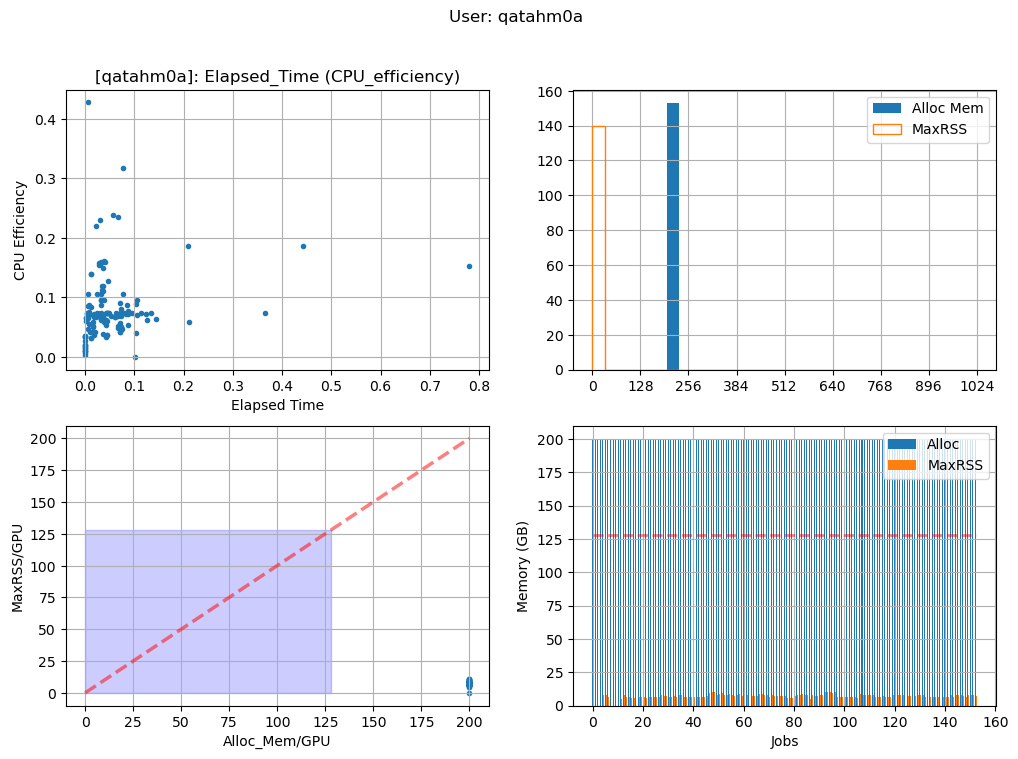

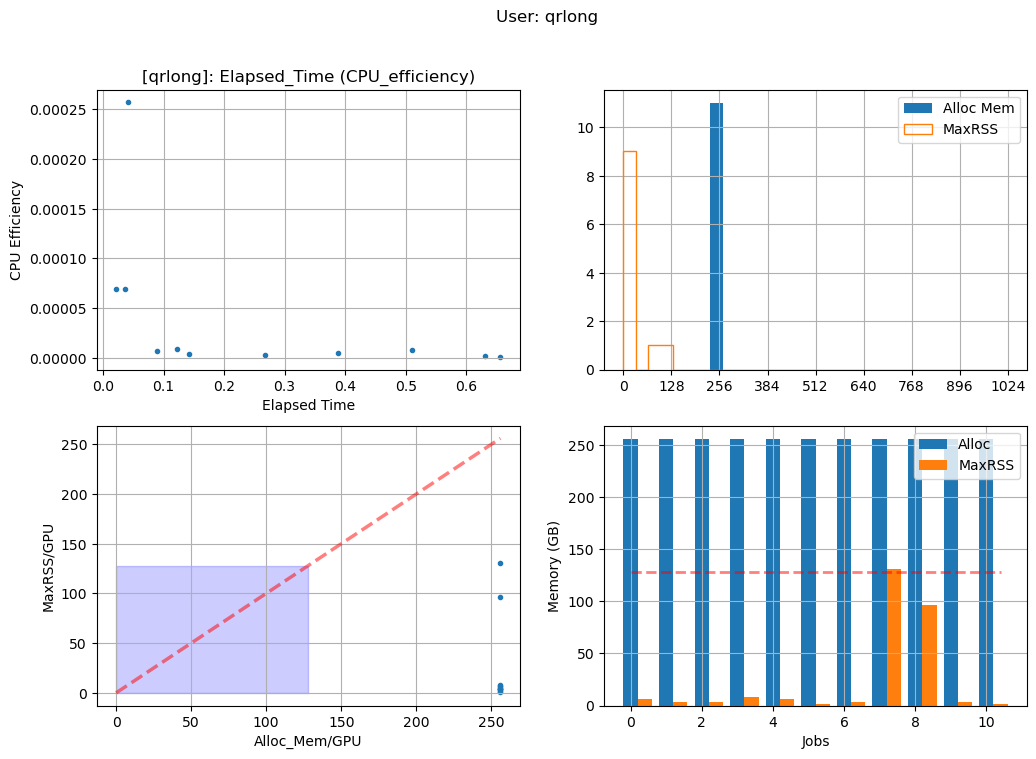

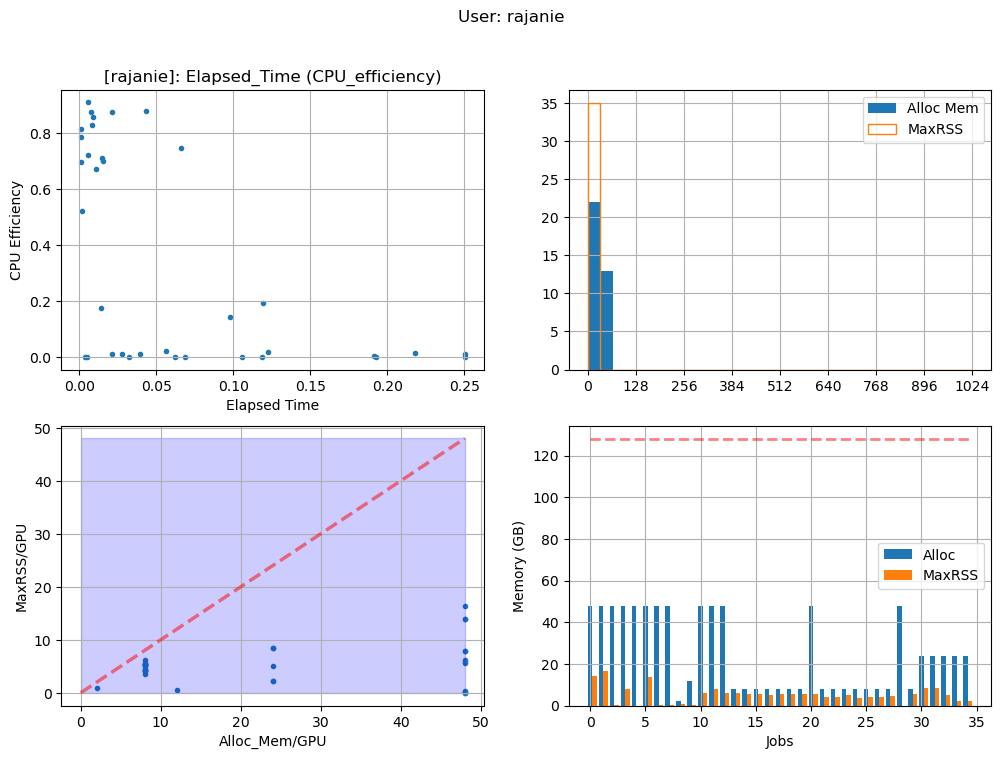

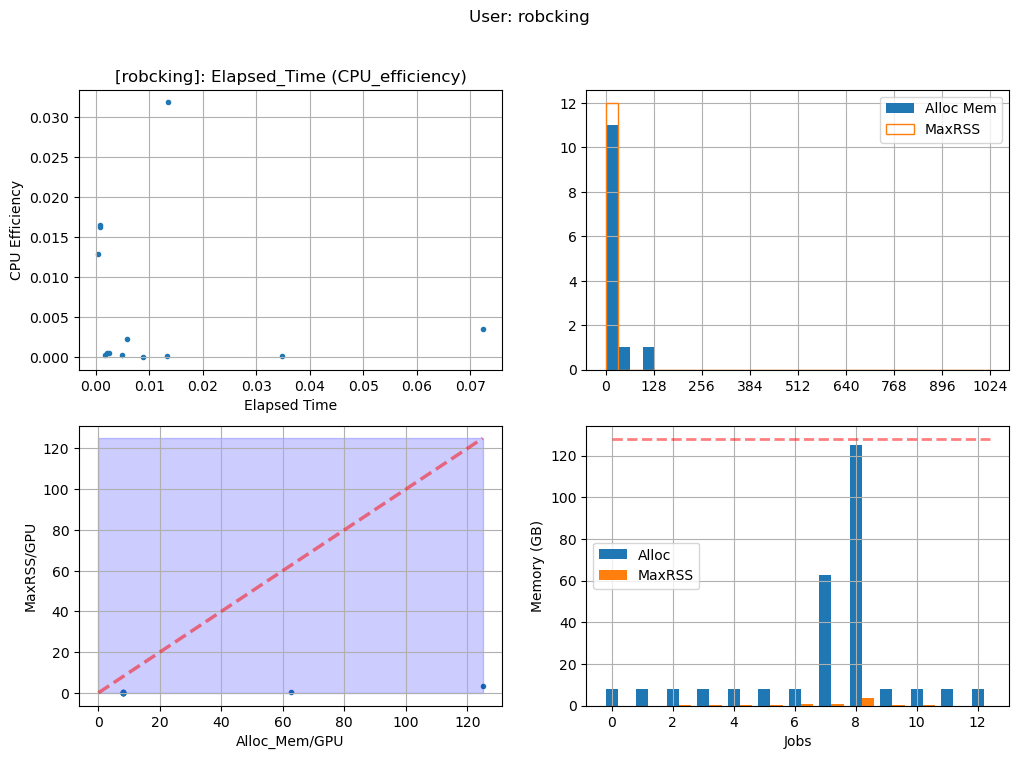

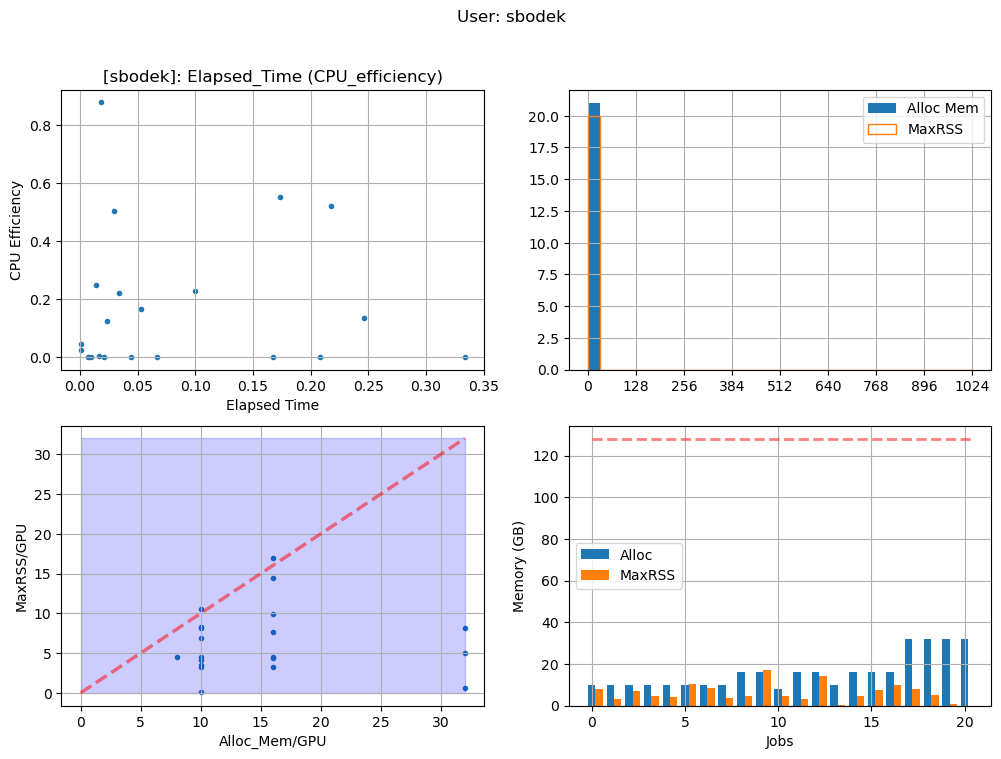

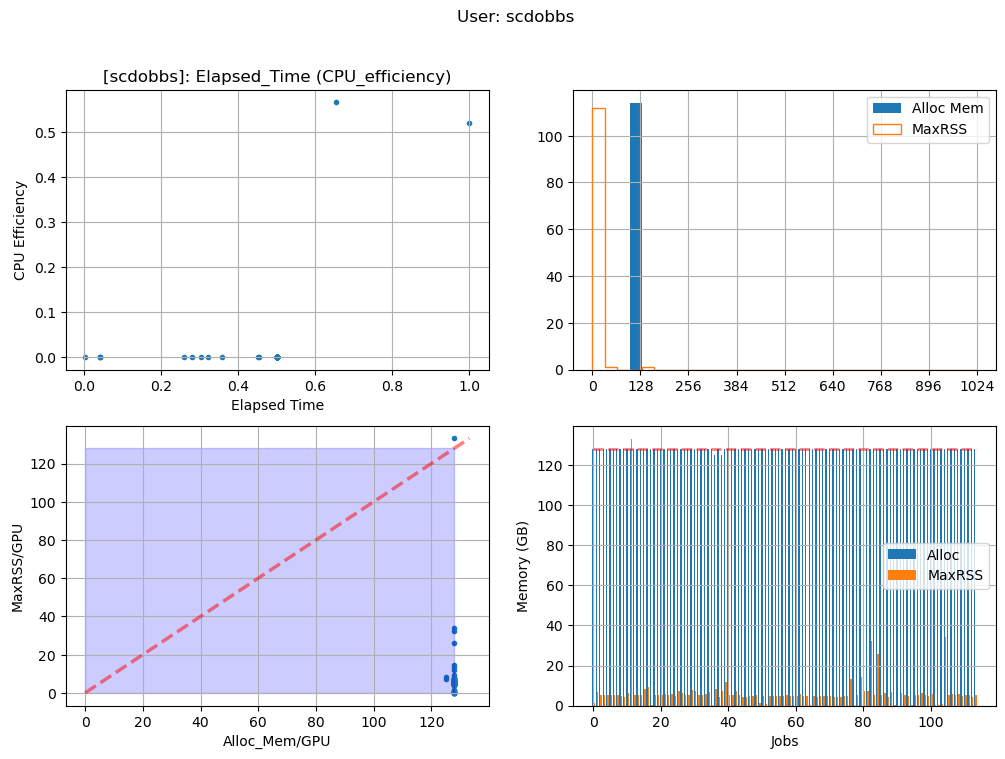

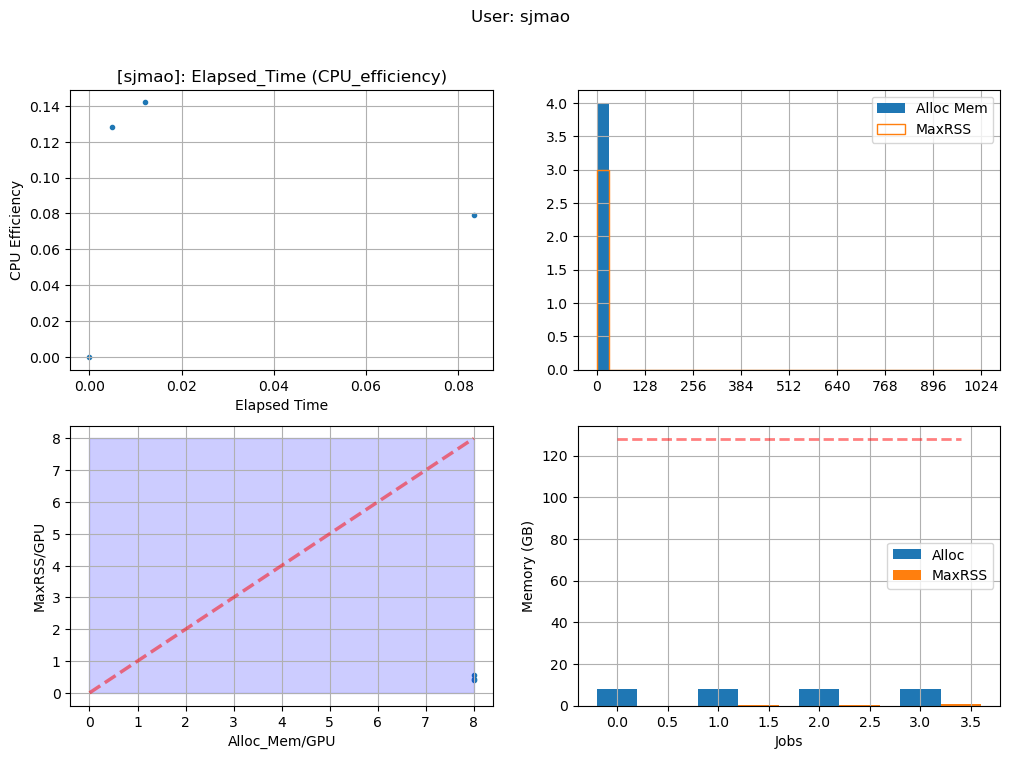

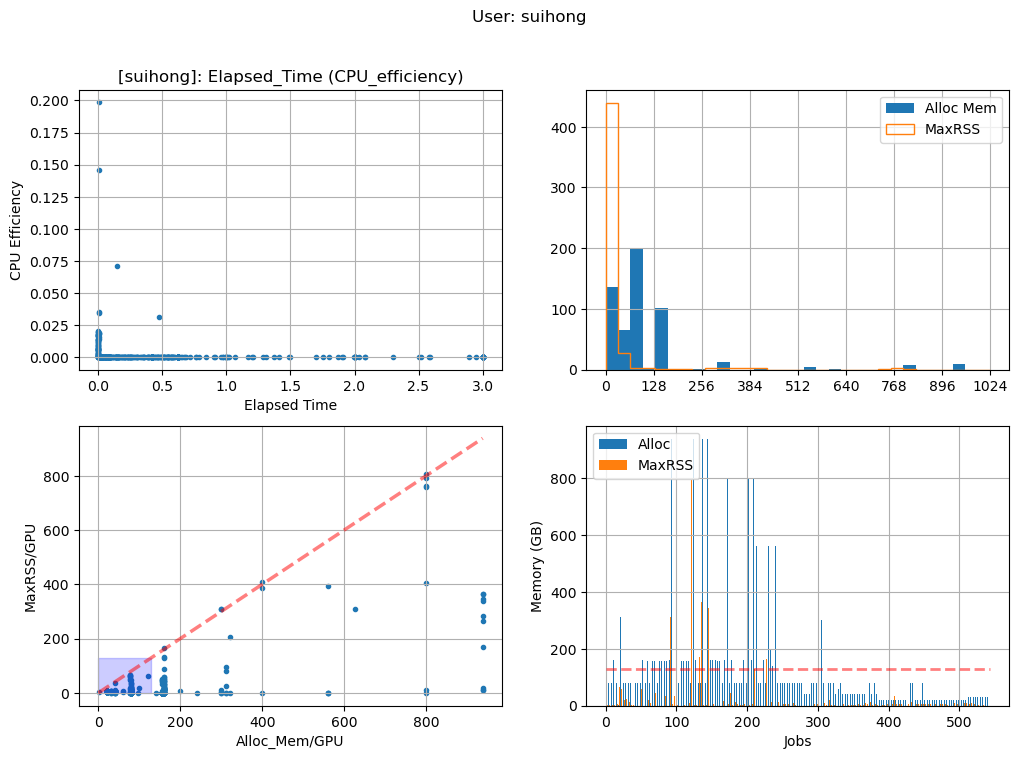

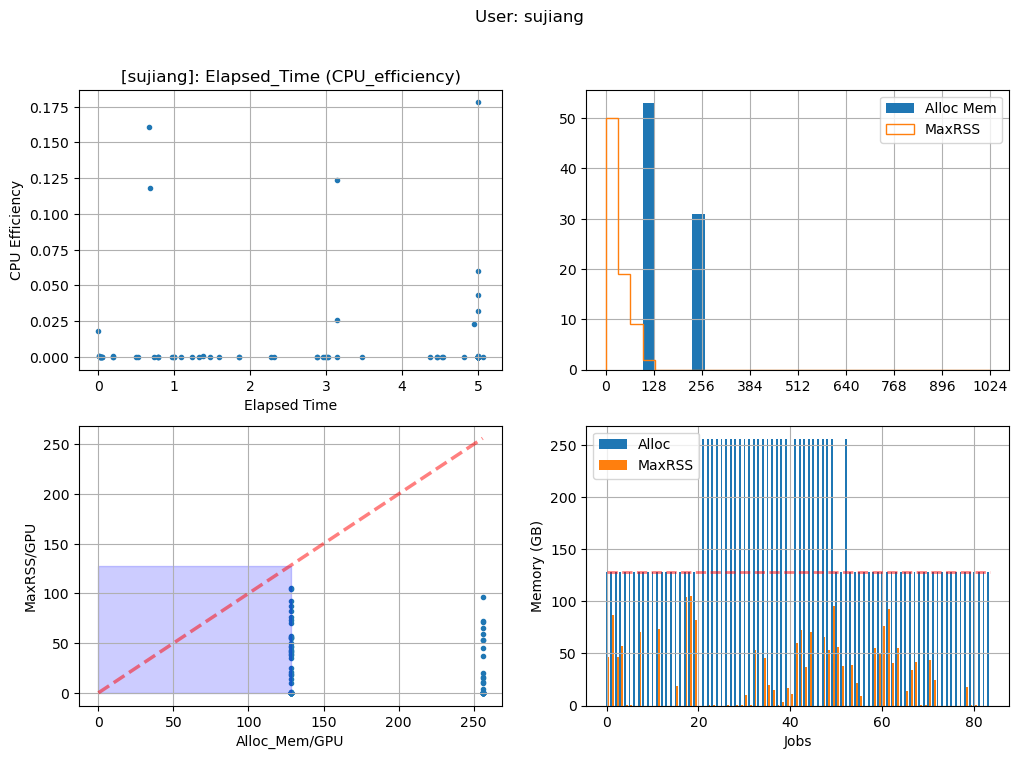

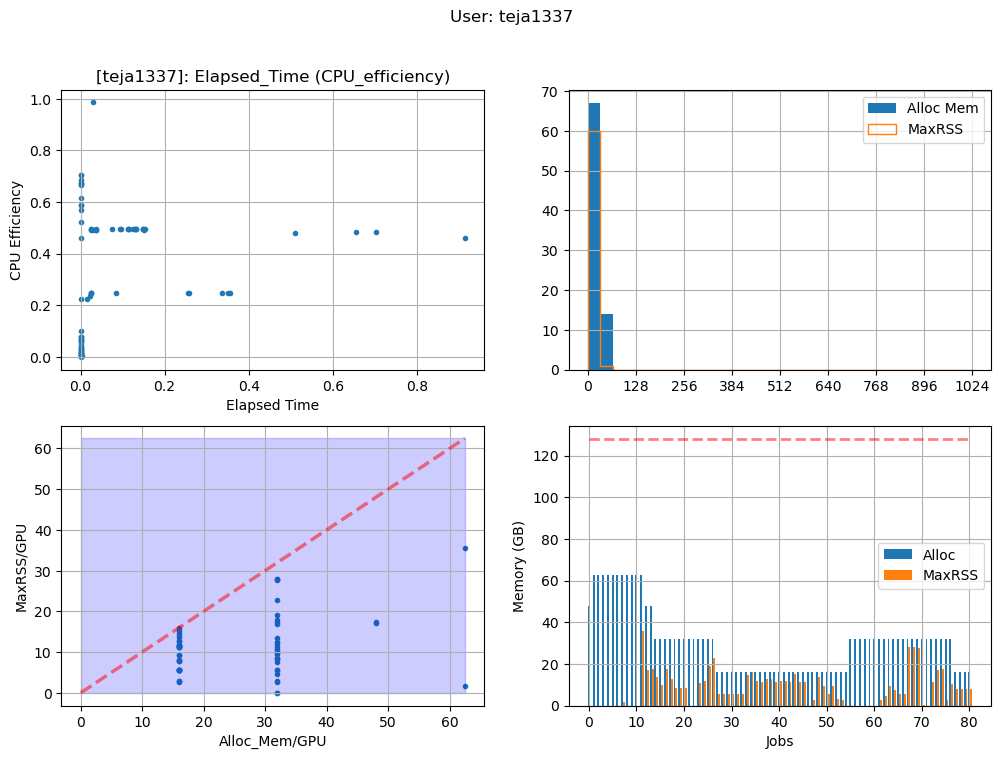

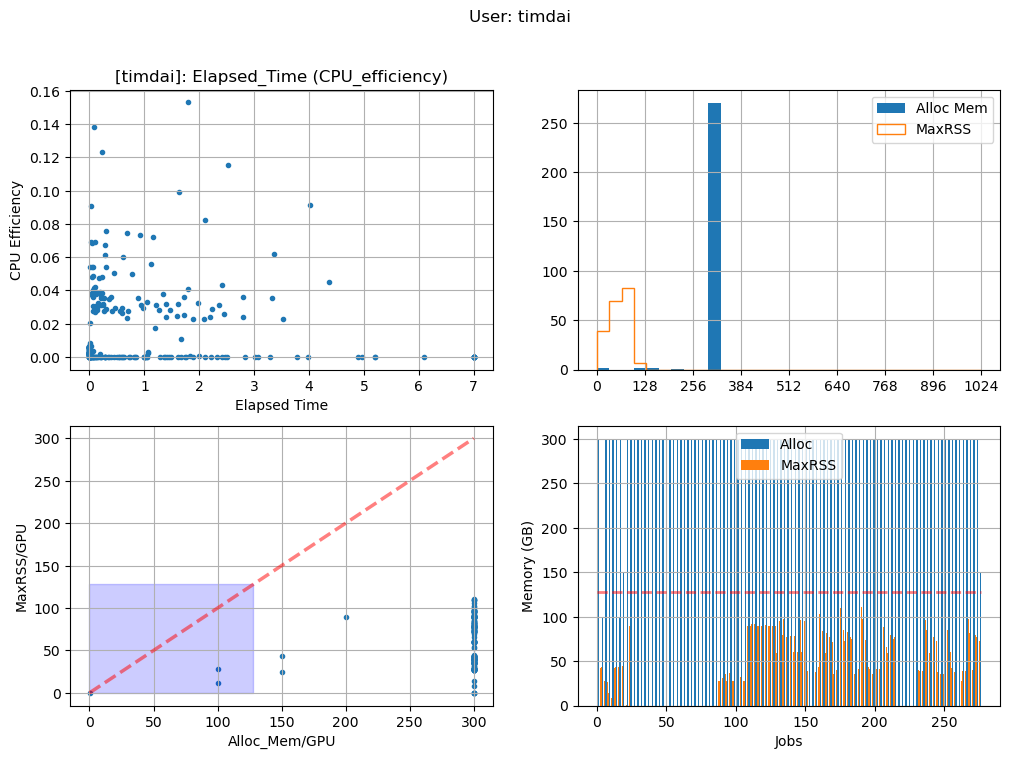

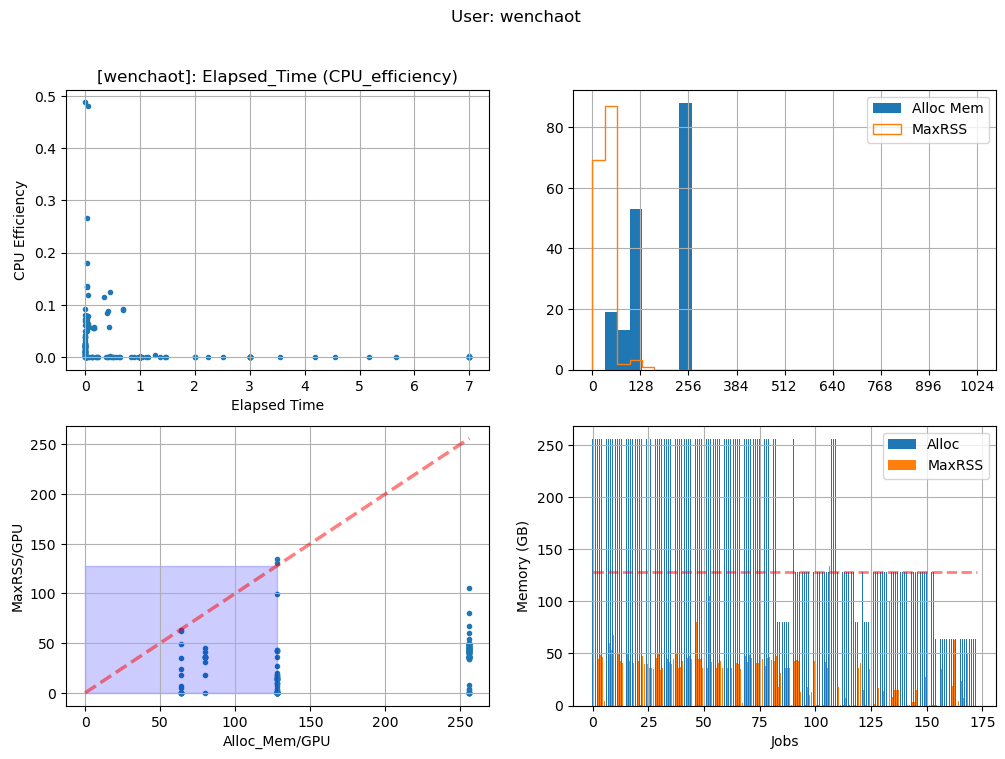

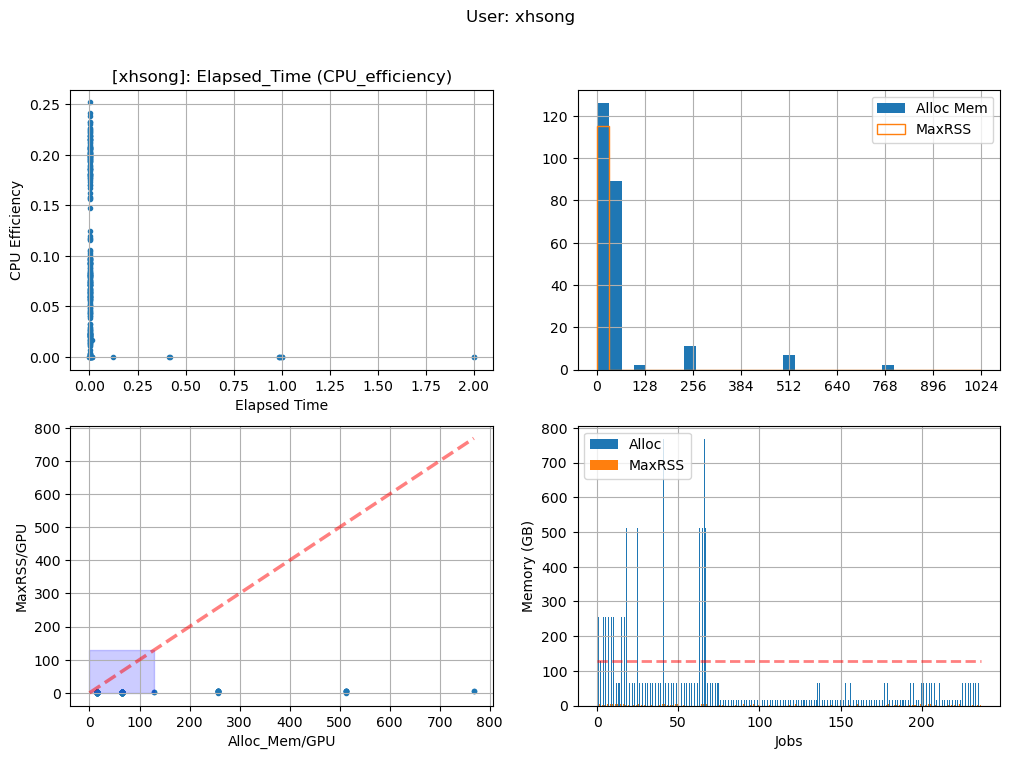

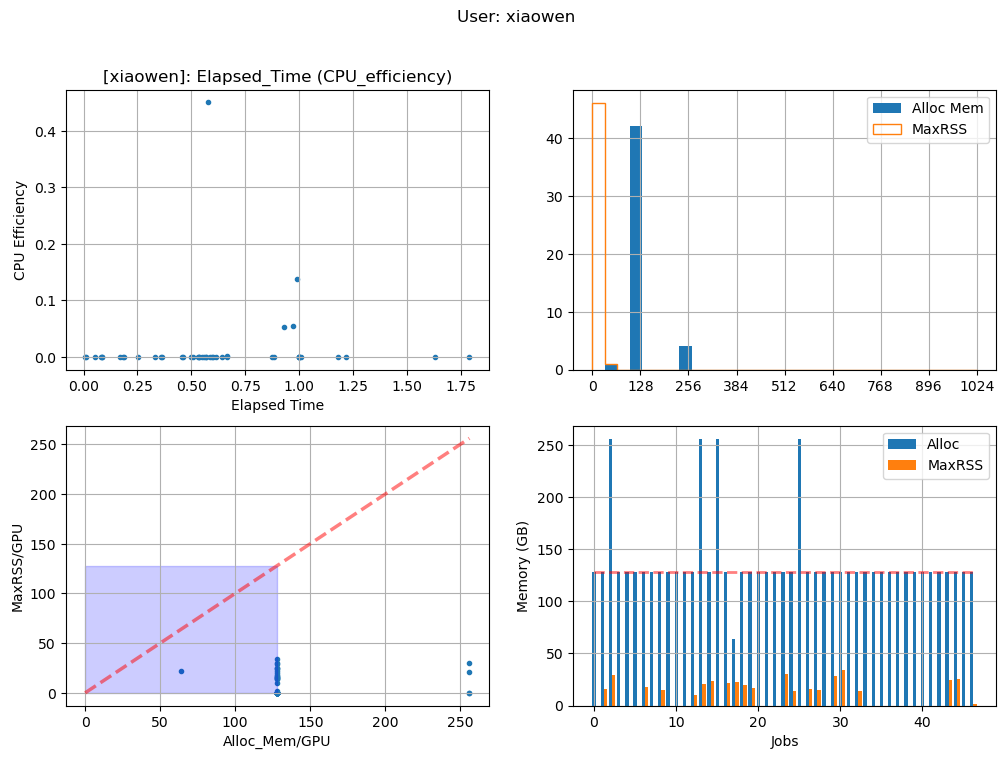

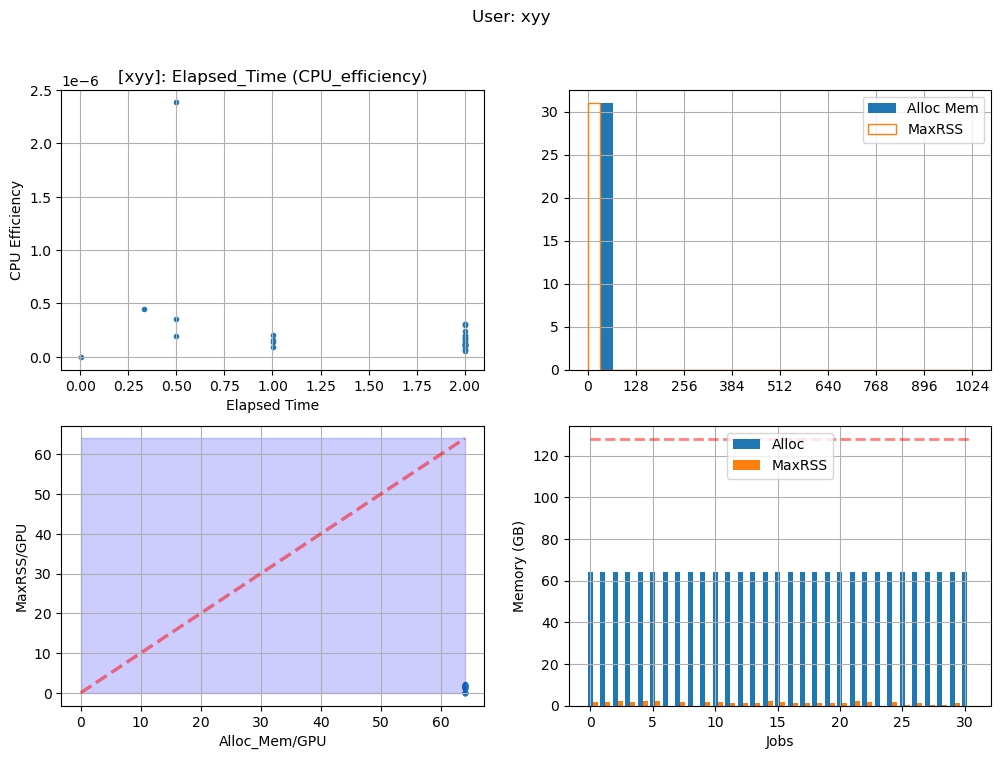

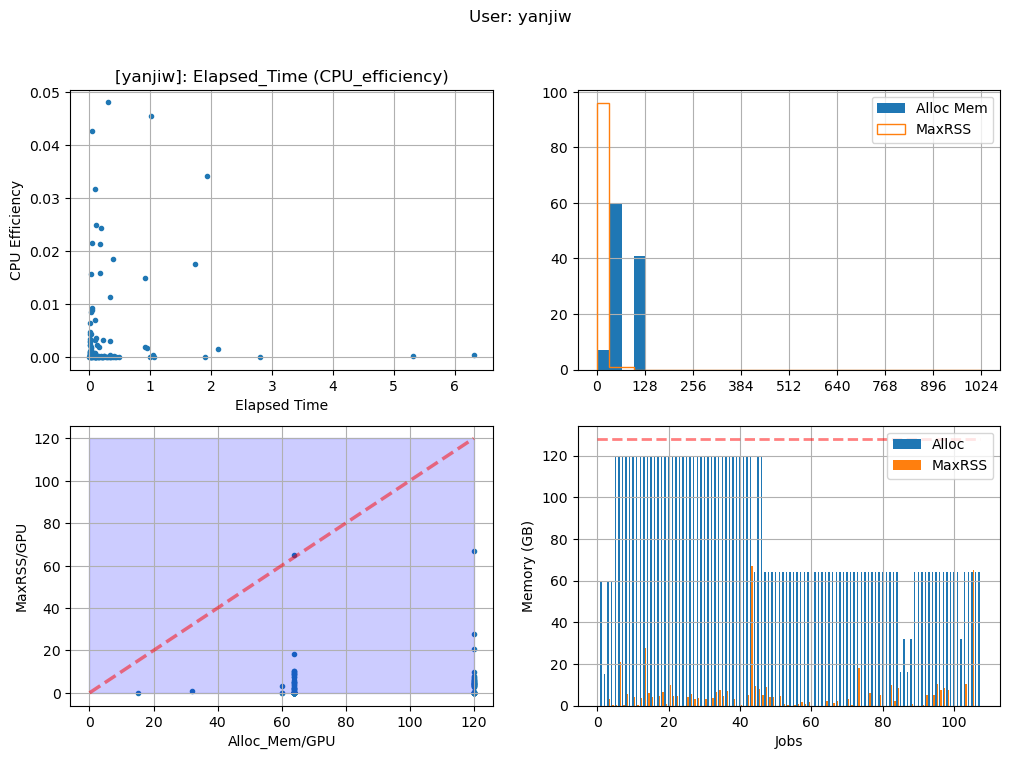

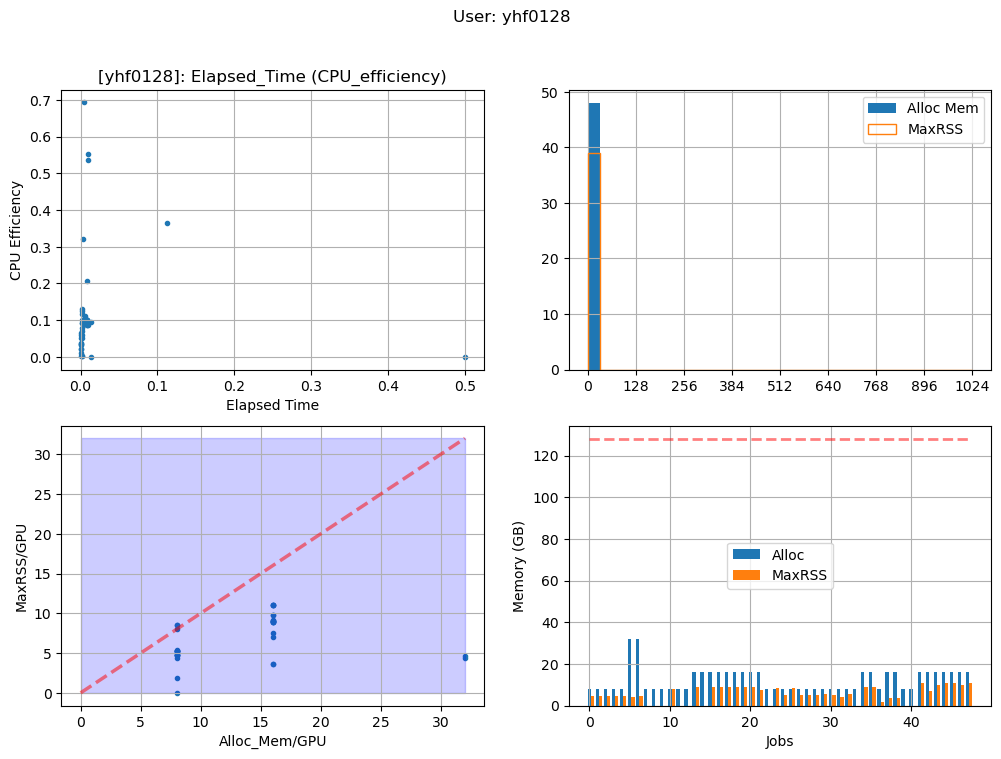

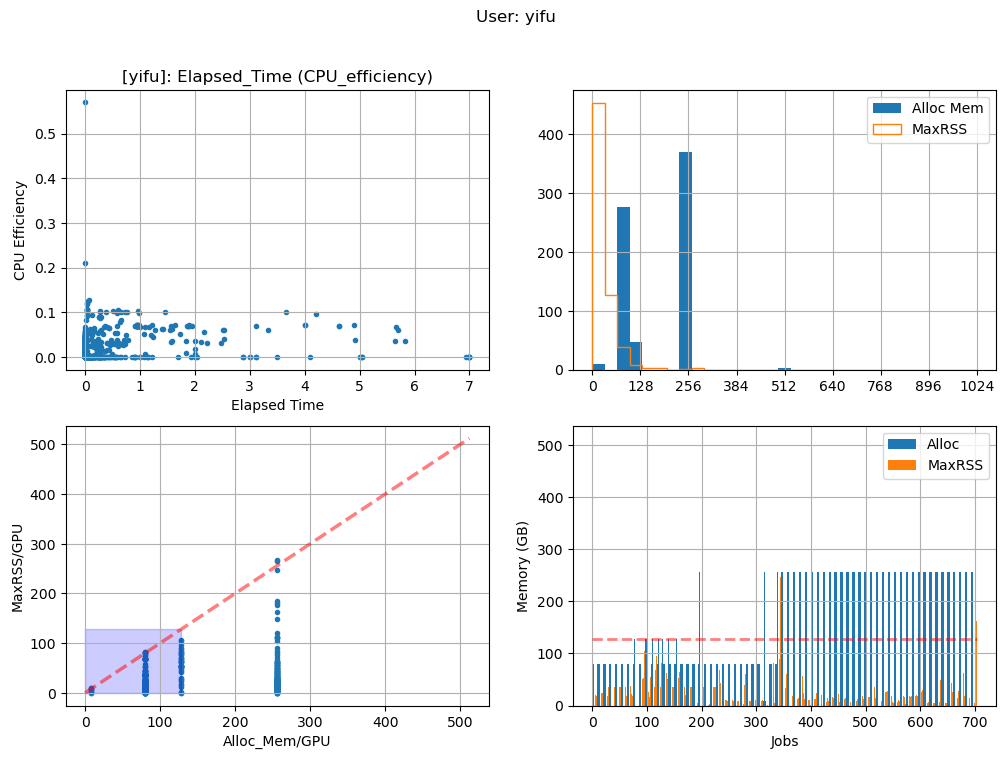

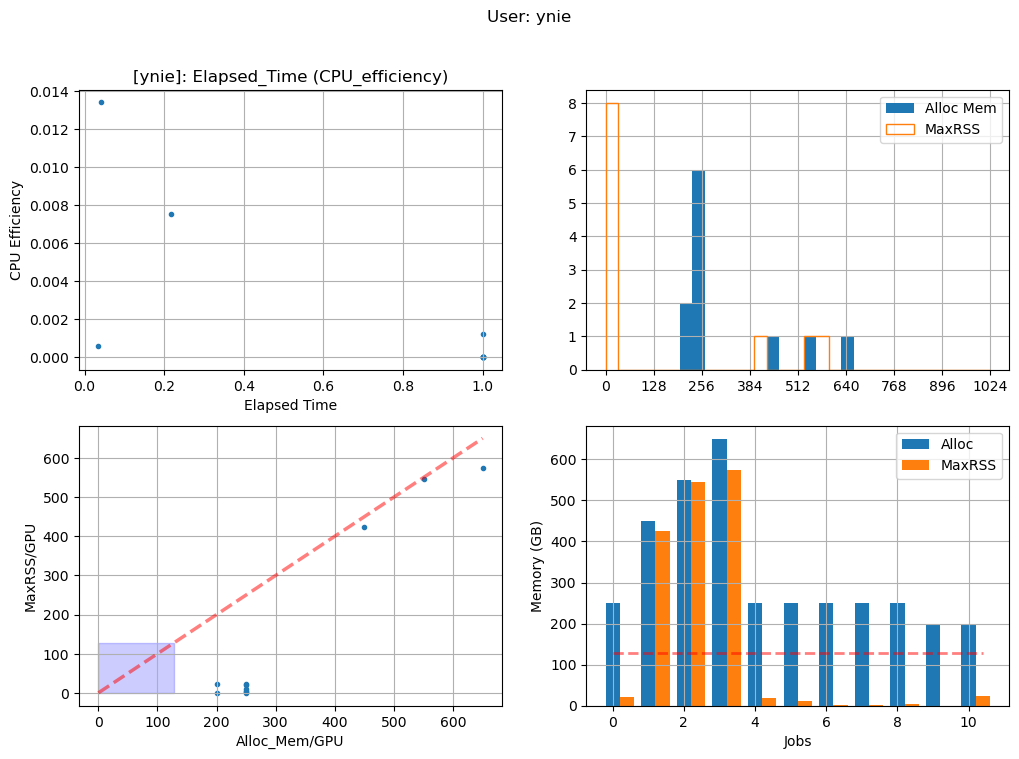

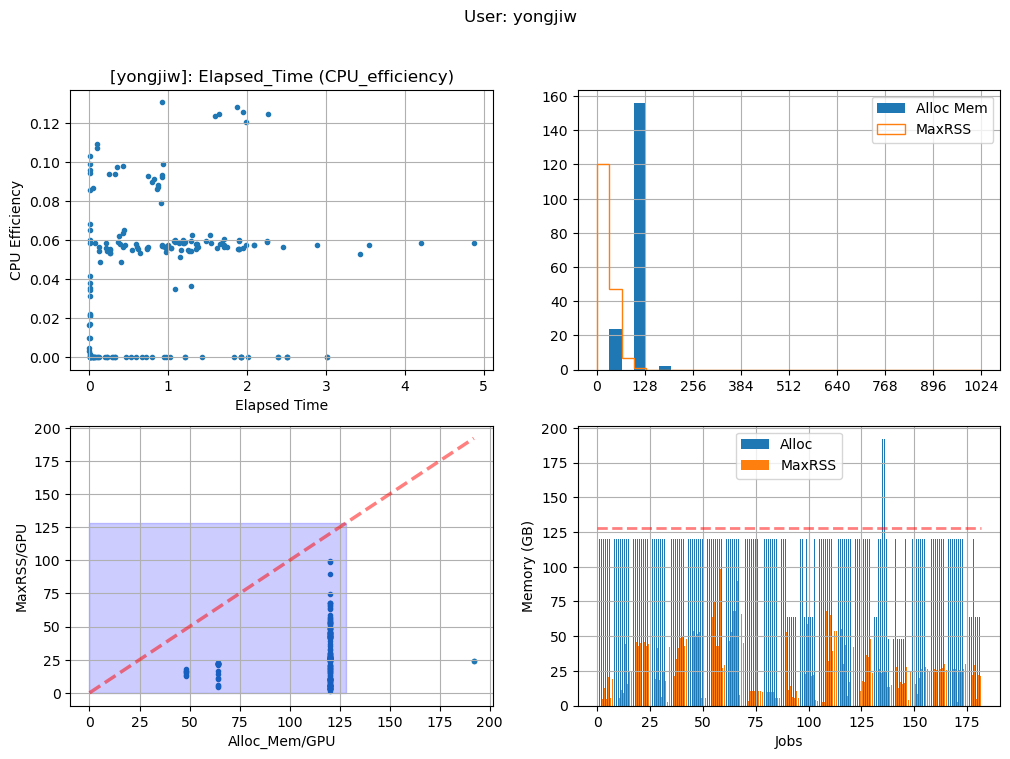

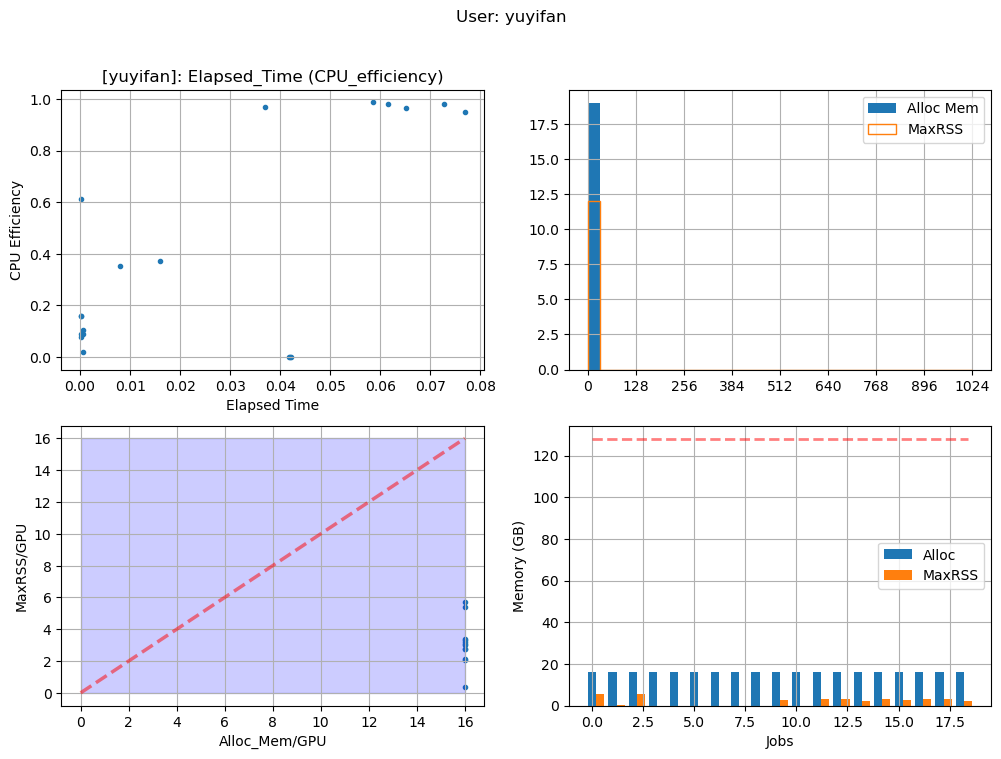

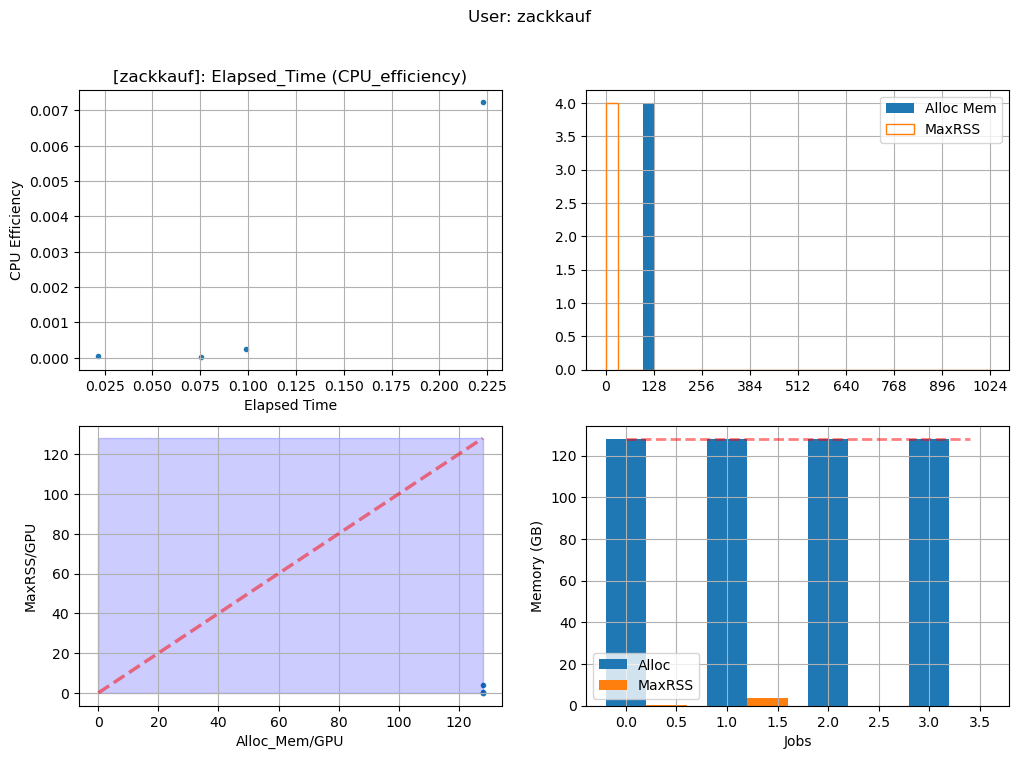

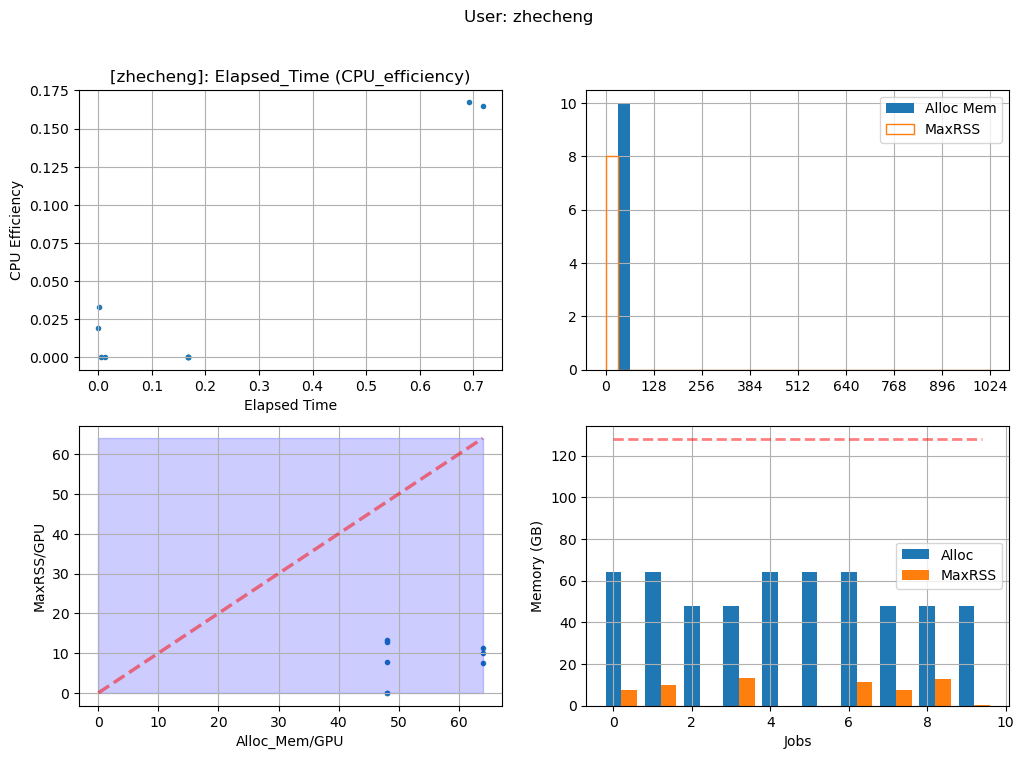

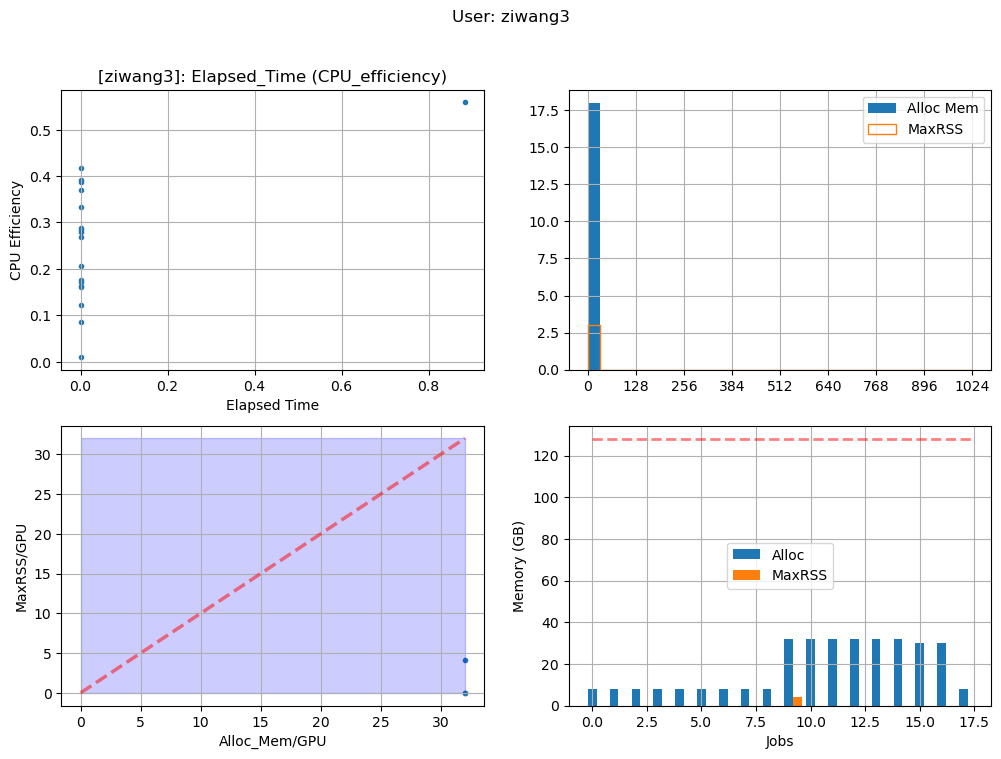

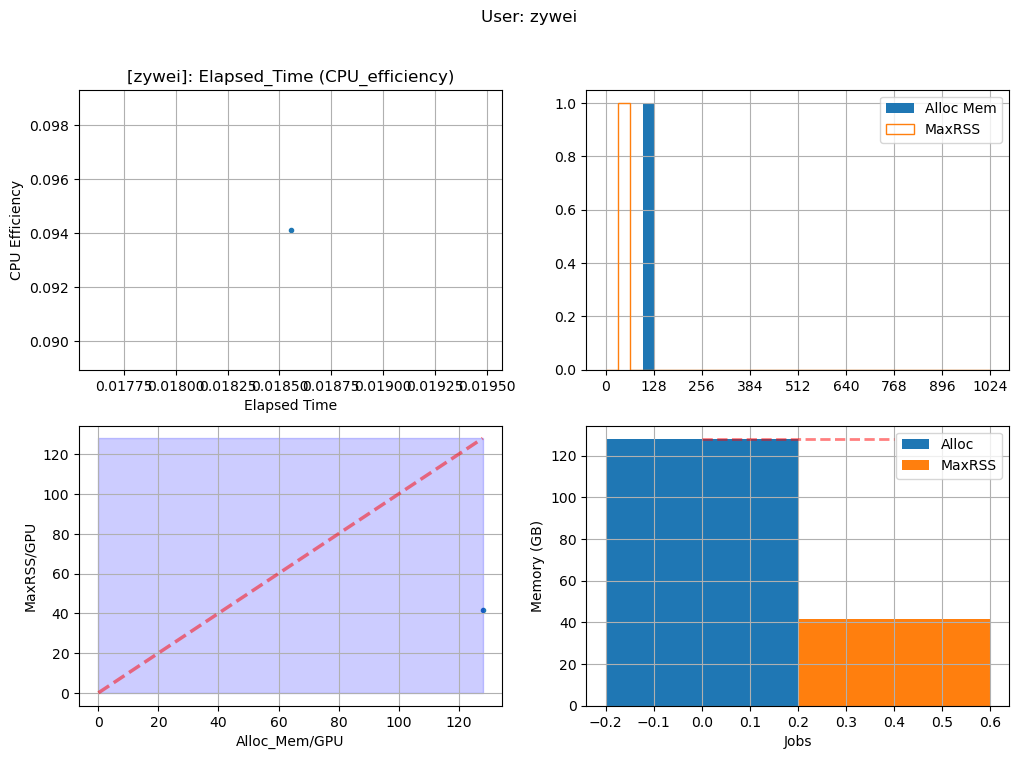

In [48]:
#
for k,usr in enumerate(gpu_users):
    #print(f'** usr: {usr}')
    fg = plt.figure(figsize=(12,8))
    ax1 = fg.add_subplot(2,2,1)
    ax2 = fg.add_subplot(2,2,2)
    ax3 = fg.add_subplot(2,2,3)
    ax4 = fg.add_subplot(2,2,4)
    #ax2 = ax1.twiny()
    sup_t = fg.suptitle(f'User: {usr}')
    #
    usr_gpu_jobs = gpu_jobs[gpu_jobs['User']==usr.encode()]
    usr_cpu_eff = usr_gpu_jobs['UserCPU']/(usr_gpu_jobs['NCPUS']*usr_gpu_jobs['Elapsed'])
    #
    usr_mem_per_gpu = (usr_gpu_jobs['ReqMem']/usr_gpu_jobs['NGPUs'])/10**9
    usr_maxrss_gpu  = (usr_gpu_jobs['MaxRSS']/usr_gpu_jobs['NGPUs'])/10**9
    #
    ax1.scatter(usr_gpu_jobs['Elapsed'], usr_cpu_eff, marker='.')
    ax1.set_title(f'[{usr}]: Elapsed_Time (CPU_efficiency)')
    ax1.set_ylabel('CPU Efficiency')
    ax1.set_xlabel('Elapsed Time')
    ax1.grid()
    #
    # bins=[0, 128,256,384,512,640,768,896,1024]
    usr_hh_gpu = ax2.hist(usr_mem_per_gpu, bins=numpy.linspace(0., 1024, 32),
                      density=False, cumulative=False, histtype='bar', label='Alloc Mem')
    usr_hh_mrss = ax2.hist(usr_maxrss_gpu, bins=numpy.linspace(0., 1024, 32),
                      density=False, cumulative=False, histtype='step', label='MaxRSS')
    loc = mpl.ticker.MultipleLocator(base=128)
    #loc2 = mpl.ticker.MultipleLocator(base=128/4)
    ax2.xaxis.set_major_locator(loc)
    #print('*** hh_gpu: ', hh_gpu[1])
    ax2.grid()
    ax2.legend(loc=0)
    #
    ax3.scatter(usr_mem_per_gpu, usr_maxrss_gpu, marker='.')
    x0 = max(numpy.append(usr_mem_per_gpu, usr_maxrss_gpu))
    ax3.plot([0., x0], [0., x0], ls='--', lw=2.5, color='r', alpha=.5)
    ax3.fill_between([0., min(x0, 128.)], [min(x0, 128.), min(x0, 128.)], [0., 0.], color='b', alpha=.2)
    ax3.grid()
    ax3.set_ylabel('MaxRSS/GPU')
    ax3.set_xlabel('Alloc_Mem/GPU')
    #
    bar_width = .4
    x_br1 = numpy.arange(len(usr_mem_per_gpu))
    x_br2 = x_br1 + bar_width
    #
    ax4.bar(x_br1, usr_mem_per_gpu, width=bar_width, lw=0., edgecolor='grey', label='Alloc')
    ax4.bar(x_br2, usr_maxrss_gpu, width=bar_width, lw=0., edgecolor='grey', label='MaxRSS')
    ax4.set_xlabel('Jobs')
    ax4.set_ylabel('Memory (GB)')
    ax4.legend(loc=0)
    ax4.grid()
    ax4.plot([x_br1[0], x_br2[-1]], [128., 128.], lw=2., ls='--', color='r', alpha=.5)
    

    
    


In [38]:
print('*** ', gpu_jobs['Elapsed'][0:10])

***  [6.480625   6.47809028 6.47640046 7.00025463 4.20914352 7.00009259
 5.00025463 5.0002662  1.91070602 1.67270833]


In [20]:
ix = gpu_jobs['ReqMem']/gpu_jobs['NGPUs']>(128*1024**3)

print('** ', numpy.sum(ix), len(gpu_jobs))

**  1749 9045
